In [ ]:
# Step 1: Mount Google Drive and Install Dependencies
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!apt update -q
!apt install -y default-jre steghide imagemagick  # Java for OpenStego, StegHide, ImageMagick for conversions
!pip install tensorflow matplotlib seaborn scikit-learn pillow  # ML and viz libs

import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50
from tensorflow.keras.applications import mobilenet_v2, vgg16, resnet50
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Lambda, BatchNormalization, Rescaling, MaxPooling2D, Flatten, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import metrics
from tensorflow.keras.initializers import Constant
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import subprocess
import zipfile
from PIL import Image
import json
import random
import time

print(tf.__version__)

Mounted at /content/drive
Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,290 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,486 kB]
Hit:13 https://ppa.launchpad

## Step 2: Download and Install Steganography Tools

- StegHide: Installed via apt (supports JPEG, BMP, WAV, AU).
- OpenStego: Download JAR from GitHub release (supports PNG, BMP for data hiding).

In [ ]:
# Step 2: Download and Install Steganography Tools

# Remove any existing files to avoid conflicts
!rm -f /content/openstego.zip /content/openstego.jar
!rm -rf /content/openstego  # Xóa thư mục cũ nếu có

# Download OpenStego ZIP from GitHub
openstego_url = 'https://github.com/syvaidya/openstego/releases/download/openstego-0.8.6/openstego-0.8.6.zip'
!wget --content-disposition -O /content/openstego.zip {openstego_url}

# Kiểm tra dung lượng file tải về
!ls -lh /content/openstego.zip
file_size = !ls -lh /content/openstego.zip | awk '{print $5}'
if '183K' not in file_size[0]:
    print("Cảnh báo: Dung lượng không khớp (expected ~183K, got", file_size[0], ")")
else:
    print("Tải thành công OpenStego ZIP")

# Giải nén file ZIP
!unzip /content/openstego.zip -d /content/openstego

# Di chuyển file JAR ra thư mục chính (đúng đường dẫn)
!mv /content/openstego/openstego-0.8.6/lib/openstego.jar /content/openstego.jar

# Kiểm tra xem file đã có chưa
!ls -lh /content/openstego.jar

# Kiểm tra cài đặt các công cụ
!steghide --version
!java -jar /content/openstego.jar --version


--2025-11-26 02:00:23--  https://github.com/syvaidya/openstego/releases/download/openstego-0.8.6/openstego-0.8.6.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/36506278/6174263f-1dcf-46db-9674-58632ff31967?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-26T02%3A49%3A19Z&rscd=attachment%3B+filename%3Dopenstego-0.8.6.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-26T01%3A49%3A05Z&ske=2025-11-26T02%3A49%3A19Z&sks=b&skv=2018-11-09&sig=x71kOukewrqO6wXa%2B2OH9FOh%2F9VvzpMdYIszVxuUUYs%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDEyMjcyMywibmJmIjoxNzY0MTIyNDIzLCJwYXRoIjoicmVsZWFzZWF

## Step 3: Download and Prepare Cover Dataset

Using BOSSBase 1.01: 10,000 512x512 grayscale PGMs. Convert to JPEG/PNG for compatibility.

In [ ]:
# Define paths
base_dir = '/content/drive/MyDrive/steganalysis_data'
os.makedirs(base_dir, exist_ok=True)
bossbase_zip = os.path.join(base_dir, 'BOSSbase_1.01.zip')
bossbase_dir = os.path.join(base_dir, 'BOSSbase') # Thư mục giải nén
cover_dir = os.path.join(base_dir, 'covers')  # Nơi lưu ảnh đã chuyển đổi

# Download BOSSBase if not exists
if not os.path.exists(bossbase_zip):
    print(f"Downloading BOSSbase to {bossbase_zip}...")
    !wget -O {bossbase_zip} http://dde.binghamton.edu/download/ImageDB/BOSSbase_1.01.zip
else:
    print("BOSSbase ZIP already downloaded.")


# Đường dẫn chính xác đến thư mục chứa file PGM (bên trong thư mục giải nén)
pgm_source_dir = os.path.join(bossbase_dir, 'BOSSbase_1.01')

# Extract if not done
if not os.path.exists(pgm_source_dir):
    print(f"Extracting {bossbase_zip} to {bossbase_dir}...")
    with zipfile.ZipFile(bossbase_zip, 'r') as zip_ref:
        zip_ref.extractall(bossbase_dir)
else:
    print("BOSSbase already extracted.")

# Convert PGMs to JPEG/PNG
os.makedirs(cover_dir, exist_ok=True)

# Lấy danh sách file PGM từ thư mục con pgm_source_dir
pgm_files = [f for f in os.listdir(pgm_source_dir) if f.endswith('.pgm')]
expected_count = len(pgm_files)  # 10000 files
print(f"Found {expected_count} PGM files in {pgm_source_dir}.")

# --- LOGIC KIỂM TRA VÀ XỬ LÝ THIẾU FILE ---

# Tính toán số lượng file JPG và PNG đã có
existing_jpg_names = {f.replace('.jpg', '') for f in os.listdir(cover_dir) if f.endswith('.jpg')}
existing_png_names = {f.replace('.png', '') for f in os.listdir(cover_dir) if f.endswith('.png')}

# Tạo danh sách các file PGM CẦN được chuyển đổi
files_to_convert = []
for pgm in pgm_files:
    base_name = pgm.replace('.pgm', '')

    # Nếu file JPG HOẶC file PNG tương ứng bị thiếu, thêm file PGM vào danh sách cần chuyển đổi
    if base_name not in existing_jpg_names or base_name not in existing_png_names:
        files_to_convert.append(pgm)

num_files_to_convert = len(files_to_convert)

# Thực thi dựa trên điều kiện
if num_files_to_convert == 0:
    # Trường hợp Đã đủ file
    print(f"Dữ liệu Cover (JPG/PNG) đã đủ {expected_count} file mỗi loại. BỎ QUA việc chuyển đổi.")
else:
    # Trường hợp chưa có gì và Trường hợp thiếu file
    print(f"BẮT ĐẦU chuyển đổi {num_files_to_convert} PGM images sang JPG và PNG...")
    print(f"(Hiện có JPG: {len(existing_jpg_names)}, PNG: {len(existing_png_names)}).")

    # Vòng lặp chỉ chạy trên danh sách file thiếu/cần cập nhật
    # print(f"Converting {len(pgm_files)} PGM images to JPG and PNG...")
    for pgm in files_to_convert:
        pgm_path = os.path.join(pgm_source_dir, pgm)
        jpg_path = os.path.join(cover_dir, pgm.replace('.pgm', '.jpg'))
        png_path = os.path.join(cover_dir, pgm.replace('.pgm', '.png'))

        base_name = pgm.replace('.pgm', '')

        # Chuyển đổi sang JPEG CHỈ KHI file JPG tương ứng CHƯA TỒN TẠI
        if base_name not in existing_jpg_names:
            print(f"Converting {base_name}.pgm -> {base_name}.jpg (Missing)")
            !convert {pgm_path} -colorspace sRGB -type TrueColor -quality 90 {jpg_path}
        else:
            print(f"Skipping {base_name}.jpg (Already exists)")

        # Chuyển đổi sang PNG CHỈ KHI file PNG tương ứng CHƯA TỒN TẠI
        if base_name not in existing_png_names:
            print(f"Converting {base_name}.pgm -> {base_name}.png (Missing)")
            !convert {pgm_path} -type TrueColor {png_path}
        else:
            print(f"Skipping {base_name}.png (Already exists)")

    print(f'Finished converting {num_files_to_convert} missing/updated images.')

BOSSbase ZIP already downloaded.
BOSSbase already extracted.
Found 10000 PGM files in /content/drive/MyDrive/steganalysis_data/BOSSbase/BOSSbase_1.01.
Dữ liệu Cover (JPG/PNG) đã đủ 10000 file mỗi loại. BỎ QUA việc chuyển đổi.


## Step 4: Generate Stego Images with Multiple Scenarios

- Scenarios: Vary bpp (0.1-0.4), formats (JPEG/PNG), tools (StegHide/OpenStego).
- Create secret message file (fixed for simplicity).
- Generate stego for each cover, with random text payload sized to match bpp.
- Structure: stego_dir/tool/format/bpp (e.g., stego_dir/steghide/jpeg/0.2)

**Note:** bpp = bits per pixel. Payload size = (bpp * width * height) / 8 bytes.

In [ ]:
stego_base_dir = os.path.join(base_dir, 'stegos')
os.makedirs(stego_base_dir, exist_ok=True)
import re # Import thư viện Regular Expression để đọc capacity

# --- CÁC HÀM TẠO PAYLOAD VÀ NHÚNG TIN ---

def generate_high_entropy_payload(size_bytes, payload_file_path = '/content/payload_real.bin'):
    """
    Tạo payload nhị phân ngẫu nhiên (entropy cao) với kích thước chỉ định.
    """
    # Đảm bảo payload có kích thước tối thiểu (10 bytes)
    safe_size = max(10, int(size_bytes))
    random_data = os.urandom(safe_size)
    with open(payload_file_path, 'wb') as f:
        f.write(random_data)
    return payload_file_path

# Function to embed with StegHide (for JPEG/BMP)
def embed_steghide(cover_path, stego_path, bpp_ratio, passphrase='password'):
    """
    Nhúng tin vào StegHide bằng cách tính capacity thực tế (payload động).
    bpp_ratio: Tỷ lệ lấp đầy (ví dụ: 0.1 nghĩa là 10% capacity).
    """
    try:
        # 1. Chạy 'steghide info' để lấy capacity tối đa
        info_cmd = ['steghide', 'info', cover_path, '-p', passphrase]


        # *** SỬA LỖI: Thêm 'stdin=subprocess.DEVNULL' để buộc chạy non-interactive ***
        result = subprocess.run(info_cmd, check=True, capture_output=True, text=True, timeout=30,
                                stdin=subprocess.DEVNULL)

        # 2. Dùng regex để trích xuất con số từ "capacity: 5.6 KByte"
        match = re.search(r'capacity:\s+([\d\.]+)\s+KByte', result.stdout)
        if not match:
            return False, f"Không thể đọc capacity từ 'steghide info' cho file {os.path.basename(cover_path)}"

        max_capacity_kb = float(match.group(1))
        max_capacity_bytes = int(max_capacity_kb * 1024) # Chuyển KByte sang bytes

        # 3. Tính toán payload_size dựa trên tỷ lệ (ratio)
        payload_size = int(max_capacity_bytes * bpp_ratio)

        if payload_size == 0:
            return False, f"Capacity quá nhỏ ({max_capacity_bytes} bytes), không thể nhúng."

        # 4. Tạo payload ngẫu nhiên với kích thước ĐỘNG
        payload_file = generate_high_entropy_payload(payload_size, f'/content/payload_{payload_size}.bin')

        # 5. Nhúng tin
        embed_cmd = ['steghide', 'embed', '-cf', cover_path, '-ef', payload_file,
                     '-sf', stego_path, '-p', passphrase, '-f']
        subprocess.run(embed_cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.PIPE, timeout=30)
        return True, None

    except subprocess.CalledProcessError as e:
        # Bắt lỗi stderr (có thể là bytes hoặc str)
        if isinstance(e.stderr, bytes):
            return False, e.stderr.decode('utf-8')
        else:
            return False, e.stderr
    except Exception as e:
        return False, str(e)

# Function to embed with OpenStego (for PNG)
def embed_openstego(cover_path, stego_path, bpp):
    """
    Nhúng tin vào OpenStego (PNG) dùng payload cố định (LSB).
    """
    try:
        # Tính payload cho LSB (PNG)
        payload_size = int((512 * 512 * bpp * 3) / 8)
        if payload_size == 0:
             return False, "Payload size là 0."

        payload_file = generate_high_entropy_payload(payload_size, f'/content/payload_{payload_size}.bin')

        subprocess.run(['java', '-jar', '/content/openstego.jar', 'embed',
                        '-a', 'randomlsb', # Dùng thuật toán LSB ngẫu nhiên
                        '-mf', payload_file,
                        '-cf', cover_path,
                        '-sf', stego_path],
                       check=True, stdout=subprocess.DEVNULL, stderr=subprocess.PIPE, timeout=30)
        return True, None
    except Exception as e:
        return False, str(e)

# --- VÒNG LẶP CHÍNH (Đã sửa logic) ---
configs = [
    # {'tool': 'steghide', 'format': 'jpg', 'bpp': 0.1},# bpp giờ là 10% capacity
    # {'tool': 'steghide', 'format': 'jpg', 'bpp': 0.2},
    # {'tool': 'steghide', 'format': 'jpg', 'bpp': 0.4},
    {'tool': 'openstego', 'format': 'png', 'bpp': 0.1},
    {'tool': 'openstego', 'format': 'png', 'bpp': 0.2},
    {'tool': 'openstego', 'format': 'png', 'bpp': 0.4},
]

print("--- Bắt đầu Step 4: Tạo Dữ liệu Stego ---")
all_covers = os.listdir(cover_dir)

for config in configs:
    tool, fmt, bpp = config['tool'], config['format'], config['bpp']
    stego_dir = os.path.join(stego_base_dir, f'{tool}_{fmt}_{bpp}')
    os.makedirs(stego_dir, exist_ok=True)
    scenario_name = f"[{tool}_{fmt}_{bpp}]"

    source_covers = [f for f in all_covers if f.endswith(f'.{fmt}')]
    existing_stegos = {f for f in os.listdir(stego_dir) if f.endswith(f'.{fmt}')}

    covers_to_process = []
    for cover_file in source_covers:
        if cover_file not in existing_stegos:
            covers_to_process.append(cover_file)

    num_to_process = len(covers_to_process)

    if num_to_process == 0:
        print(f"\nKịch bản {scenario_name} đã có đủ {len(source_covers)} file stego. BỎ QUA.")
    else:
        print(f"\nBẮT ĐẦU tạo {num_to_process} file stego bị thiếu cho kịch bản {scenario_name}...")

        processed_count = 0
        error_count = 0

        # Lặp qua các file CẦN xử lý
        for i, cover_file in enumerate(covers_to_process):
            cover_path = os.path.join(cover_dir, cover_file)
            stego_path = os.path.join(stego_dir, cover_file)

            success = False
            error_msg = ""

            if tool == 'steghide':
                success, error_msg = embed_steghide(cover_path, stego_path, bpp_ratio=bpp)
            elif tool == 'openstego':
                success, error_msg = embed_openstego(cover_path, stego_path, bpp=bpp)

            if success:
                processed_count += 1
            else:
                error_count += 1
                if error_count <= 10:
                    print(f'  LỖI: Failed {cover_file} với {tool}. Lý do: {error_msg}')
                elif error_count == 11:
                    print('  ...Và nhiều lỗi khác (sẽ không in thêm).')

            if (i+1) % 1000 == 0: # In tiến độ
                print(f"  ...Đã xử lý {i+1}/{num_to_process} (thành công {processed_count}, thất bại {error_count})...")

        # In kết quả cuối cùng
        print(f'Hoàn thành {scenario_name}. Đã tạo mới {processed_count} file stego. (Thất bại: {error_count})')

print('\n--- Hoàn thành Step 4 ---')

--- Bắt đầu Step 4: Tạo Dữ liệu Stego ---

Kịch bản [openstego_png_0.1] đã có đủ 10000 file stego. BỎ QUA.

Kịch bản [openstego_png_0.2] đã có đủ 10000 file stego. BỎ QUA.

Kịch bản [openstego_png_0.4] đã có đủ 10000 file stego. BỎ QUA.

--- Hoàn thành Step 4 ---


##  Giai đoạn 1: Tạo Toàn bộ Dữ liệu TFRecord

### Step 5: Prepare Datasets for Training (Multiple Scenarios)

- For each config, create train/val/test dirs with cover/stego subdirs.
- Split 70/15/15, ensure no leakage (hash check optional).
- Balance classes.

In [ ]:
import tensorflow as tf
import pandas as pd
import json
import os
import random
import numpy as np
import shutil

# (Đảm bảo tên đường dẫn này đúng)
base_dir = '/content/drive/MyDrive/steganalysis_data'
cover_dir = os.path.join(base_dir, 'covers')
stego_base_dir = os.path.join(base_dir, 'stegos')

# --- CHẠY TOÀN BỘ 6 KỊCH BẢN ---
configs = [
    # {'tool': 'steghide', 'format': 'jpg', 'bpp': 0.1},
    # {'tool': 'steghide', 'format': 'jpg', 'bpp': 0.2},
    # {'tool': 'steghide', 'format': 'jpg', 'bpp': 0.4},
    {'tool': 'openstego', 'format': 'png', 'bpp': 0.1},
    {'tool': 'openstego', 'format': 'png', 'bpp': 0.2},
    {'tool': 'openstego', 'format': 'png', 'bpp': 0.4},
]


# --- Helper Functions cho TFRecord ---
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))): value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_image_example(image_path, label):
    try:
        image_bytes = tf.io.read_file(image_path)
        feature = {
            'image_raw': _bytes_feature(image_bytes),
            'label': _int64_feature(label),
        }
        example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()
    except Exception as e:
        print(f"LỖI ĐỌC FILE (Bỏ qua): {image_path} - {e}")
        return None

# --- HÀM PREPARE_DATASET ---
def prepare_dataset(config, ratio=(0.7, 0.15, 0.15)):
    tool, fmt, bpp = config['tool'], config['format'], config['bpp']
    scenario_key = f'{tool}_{fmt}_{bpp}'
    scenario_dir = os.path.join(base_dir, f'scenario_{scenario_key}')
    os.makedirs(scenario_dir, exist_ok=True)

    train_tfrecord = os.path.join(scenario_dir, 'train.tfrecord')
    val_tfrecord = os.path.join(scenario_dir, 'val.tfrecord')
    test_tfrecord = os.path.join(scenario_dir, 'test.tfrecord')

    if os.path.exists(train_tfrecord) and os.path.exists(val_tfrecord) and os.path.exists(test_tfrecord):
        print(f"TFRecords for {scenario_key} đã được tạo. BỎ QUA.")
        return scenario_dir

    print(f"BẮT ĐẦU tạo file TFRecord cho kịch bản {scenario_key}...")

    covers_list = [f for f in os.listdir(cover_dir) if f.endswith(f'.{fmt}')]
    stegos_dir = os.path.join(stego_base_dir, scenario_key)
    stegos_list_names = {f for f in os.listdir(stegos_dir) if f.endswith(f'.{fmt}')}

    paired = []
    for cover_file in covers_list:
        if cover_file in stegos_list_names:
            paired.append((
                os.path.join(cover_dir, cover_file),
                os.path.join(stegos_dir, cover_file)
            ))
    n = len(paired)
    if n < 10000: # Cảnh báo nếu thiếu dữ liệu
        print(f"CẢNH BÁO: Chỉ tìm thấy {n} cặp dữ liệu cho {scenario_key}. (Kỳ vọng 10000).")
        if n == 0:
            print(f"LỖI: Không tìm thấy dữ liệu cho kịch bản này.")
            return scenario_dir

    random.shuffle(paired)
    train_end = int(n * ratio[0])
    val_end = train_end + int(n * ratio[1])
    splits = {'train': (paired[:train_end], train_tfrecord),
              'val': (paired[train_end:val_end], val_tfrecord),
              'test': (paired[val_end:], test_tfrecord)}

    for split_name, (pairs, tfrecord_path) in splits.items():
        count = 0
        with tf.io.TFRecordWriter(tfrecord_path) as writer:
            for cover_path, stego_path in pairs:
                serialized_cover = serialize_image_example(cover_path, 0)
                serialized_stego = serialize_image_example(stego_path, 1)
                if serialized_cover and serialized_stego:
                    writer.write(serialized_cover) # Nhãn 0 (Cover)
                    writer.write(serialized_stego) # Nhãn 1 (Stego)
                    count += 2
        print(f"Đã ghi {count} ảnh vào {split_name}.tfrecord")
    return scenario_dir

# --- Vòng lặp thực thi ---
scenario_dirs_all = {}
print("--- Bắt đầu Step 5: Tạo file TFRecord (TOÀN BỘ 6 KỊCH BẢN) ---")
for config in configs:
    scenario_key = f'{config["tool"]}_{config["format"]}_{config["bpp"]}'
    scenario_dirs_all[scenario_key] = prepare_dataset(config)
print("--- Hoàn thành Step 5 (Tất cả TFRecord đã sẵn sàng) ---")

--- Bắt đầu Step 5: Tạo file TFRecord (TOÀN BỘ 6 KỊCH BẢN) ---
TFRecords for openstego_png_0.1 đã được tạo. BỎ QUA.
TFRecords for openstego_png_0.2 đã được tạo. BỎ QUA.
TFRecords for openstego_png_0.4 đã được tạo. BỎ QUA.
--- Hoàn thành Step 5 (Tất cả TFRecord đã sẵn sàng) ---


## Giai đoạn 2: 3 Phiên huấn luyện (GPU)

### Step 6: Model Building and Training Functions

- Build model with optional HPF.
- Train function with hyperparams.
- Ablation: Toggle HPF, augmentation levels.

In [ ]:
# --- 1. CÁC THAM SỐ VÀ HÀM TẢI DỮ LIỆU (ĐÃ SỬA LỖI) ---
img_size = (224, 224)

# Tính toán số lượng mẫu dựa trên 10,000 cặp và tỷ lệ 70:15:15
NUM_TRAIN_SAMPLES = 10000 * 0.7 * 2 # 14000 (cover + stego)
NUM_VAL_SAMPLES = 10000 * 0.15 * 2   # 3000
NUM_TEST_SAMPLES = 10000 * 0.15 * 2  # 3000

image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_image_function(example_proto):
    features = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.io.decode_image(features['image_raw'], channels=3)
    image = tf.cast(image, tf.float32) # Giữ lại [0-255], float32
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, img_size)
    image = tf.ensure_shape(image, (*img_size, 3))
    label = tf.cast(features['label'], tf.int32)
    return image, label

def load_dataset_fixed(tfrecord_path, batch_size, is_training=True):
    """
    Hàm tải dữ liệu đã sửa lỗi (từ Cell Test):
    1. KHÔNG augmentation (để tránh rò rỉ nội dung).
    2. CÓ .repeat() (để huấn luyện nhiều epoch).
    """
    AUTOTUNE = tf.data.AUTOTUNE
    try:
        dataset = tf.data.TFRecordDataset(tfrecord_path, num_parallel_reads=AUTOTUNE)
    except tf.errors.NotFoundError:
        print(f"LỖI: Không tìm thấy file {tfrecord_path}")
        return None

    dataset = dataset.map(_parse_image_function, num_parallel_calls=AUTOTUNE)

    if is_training:
        dataset = dataset.shuffle(buffer_size=2048)
        dataset = dataset.repeat() # FIX: Lặp lại dataset huấn luyện
        # FIX: ĐÃ XÓA AUGMENTATION (nguyên nhân lỗi 50%)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

# --- 2. CÁC KHỐI XÂY DỰNG SRM (TỪ CELL TEST) ---
@tf.keras.utils.register_keras_serializable()
class SRMFilterInitializer(tf.keras.initializers.Initializer):
    def __init__(self):
        filters = np.zeros([5, 5, 1, 30], dtype=np.float32)
        filters[2, 2, 0, 0] = -1; filters[2, 3, 0, 0] = 1
        filters[2, 2, 0, 1] = -1; filters[3, 2, 0, 1] = 1
        filters[1, 2, 0, 2] = -1; filters[3, 2, 0, 2] = 1
        filters[2, 1, 0, 3] = -1; filters[2, 3, 0, 3] = 1
        filters[1, 1, 0, 4] = -1; filters[3, 3, 0, 4] = 1
        filters[1, 3, 0, 5] = -1; filters[3, 1, 0, 5] = 1
        filters[1, 2, 0, 6] = -1; filters[2, 1, 0, 6] = 1; filters[2, 3, 0, 6] = 1; filters[3, 2, 0, 6] = 1
        filters[1, 1, 0, 7] = -1; filters[1, 3, 0, 7] = 1; filters[3, 1, 0, 7] = 1; filters[3, 3, 0, 7] = -1
        filters[2, 1, 0, 8] = 1; filters[2, 2, 0, 8] = -2; filters[2, 3, 0, 8] = 1
        filters[1, 2, 0, 9] = 1; filters[2, 2, 0, 9] = -2; filters[3, 2, 0, 9] = 1
        filters[1, 1, 0, 10] = 1; filters[2, 2, 0, 10] = -2; filters[3, 3, 0, 10] = 1
        filters[1, 3, 0, 11] = 1; filters[2, 2, 0, 11] = -2; filters[3, 1, 0, 11] = 1
        filters[1, 2, 0, 12] = -1; filters[2, 1, 0, 12] = 2; filters[2, 2, 0, 12] = -2; filters[2, 3, 0, 12] = 2; filters[3, 2, 0, 12] = -1
        filters[1, 1, 0, 13] = -1; filters[1, 3, 0, 13] = 2; filters[2, 2, 0, 13] = -2; filters[3, 1, 0, 13] = 2; filters[3, 3, 0, 13] = -1
        filters[1, 2, 0, 14] = -1; filters[2, 2, 0, 14] = 2; filters[2, 3, 0, 14] = -2; filters[3, 3, 0, 14] = 2; filters[3, 2, 0, 14] = -1
        filters[1, 3, 0, 15] = -1; filters[2, 3, 0, 15] = 2; filters[2, 2, 0, 15] = -2; filters[3, 2, 0, 15] = 2; filters[3, 1, 0, 15] = -1
        filters[1, 1, 0, 16] = 1; filters[1, 2, 0, 16] = -2; filters[2, 1, 0, 16] = -2; filters[2, 2, 0, 16] = 4
        filters[1, 2, 0, 17] = 1; filters[1, 3, 0, 17] = -2; filters[2, 2, 0, 17] = -2; filters[2, 3, 0, 17] = 4
        filters[2, 1, 0, 18] = 1; filters[2, 2, 0, 18] = -2; filters[3, 1, 0, 18] = -2; filters[3, 2, 0, 18] = 4
        filters[2, 2, 0, 19] = 1; filters[2, 3, 0, 19] = -2; filters[3, 2, 0, 19] = -2; filters[3, 3, 0, 19] = 4
        filters[2, 2, 0, 20] = -1; filters[2, 3, 0, 20] = 1
        filters[2, 2, 0, 21] = -1; filters[3, 2, 0, 21] = 1
        filters[1, 1, 0, 22] = -1; filters[1, 4, 0, 22] = 1; filters[2, 2, 0, 22] = -1; filters[2, 3, 0, 22] = 1; filters[3, 1, 0, 22] = 1; filters[3, 4, 0, 22] = -1; filters[4, 2, 0, 22] = 1; filters[4, 3, 0, 22] = -1
        filters[1, 1, 0, 23] = -1; filters[1, 3, 0, 23] = 1; filters[2, 2, 0, 23] = 1; filters[2, 4, 0, 23] = -1; filters[3, 1, 0, 23] = 1; filters[3, 3, 0, 23] = -1; filters[4, 2, 0, 23] = -1; filters[4, 4, 0, 23] = 1
        filters[1, 2, 0, 24] = -1; filters[2, 1, 0, 24] = 1; filters[2, 3, 0, 24] = -1; filters[3, 2, 0, 24] = 1; filters[3, 4, 0, 24] = 1; filters[4, 1, 0, 24] = -1; filters[4, 3, 0, 24] = 1
        filters[1, 3, 0, 25] = -1; filters[2, 2, 0, 25] = 1; filters[2, 4, 0, 25] = -1; filters[3, 1, 0, 25] = 1; filters[3, 3, 0, 25] = 1; filters[4, 2, 0, 25] = -1; filters[4, 4, 0, 25] = 1
        filters[1, 4, 0, 26] = 1; filters[2, 1, 0, 26] = -1; filters[2, 3, 0, 26] = 1; filters[3, 2, 0, 26] = -1; filters[3, 4, 0, 26] = 1; filters[4, 1, 0, 26] = 1; filters[4, 3, 0, 26] = -1
        filters[1, 3, 0, 27] = 1; filters[2, 2, 0, 27] = -1; filters[2, 4, 0, 27] = 1; filters[3, 1, 0, 27] = -1; filters[3, 3, 0, 27] = 1; filters[4, 2, 0, 27] = 1; filters[4, 4, 0, 27] = -1
        filters[2, 1, 0, 28] = 1; filters[2, 2, 0, 28] = -2; filters[2, 3, 0, 28] = 1
        filters[1, 2, 0, 29] = 1; filters[2, 2, 0, 29] = -2; filters[3, 2, 0, 29] = 1
        self.filters = tf.convert_to_tensor(filters, dtype=tf.float32)
    def __call__(self, shape, dtype=None):
        assert shape[0:3] == (5, 5, 1)
        return self.filters
    def get_config(self):
        return {}
def TLU(x, T=3.0):
    return tf.where(tf.abs(x) >= T, x, tf.zeros_like(x))

def build_srm_branch(input_layer, num_srm_filters=30):
    gray_input = Lambda(tf.image.rgb_to_grayscale, name="To_Grayscale")(input_layer)
    srm_init = SRMFilterInitializer()
    noise_features = Conv2D(num_srm_filters, (5, 5), kernel_initializer=srm_init,
                            trainable=False, padding='same', name="SRM_Filter_Bank")(gray_input)
    tlu_features = Lambda(lambda x: TLU(x, T=3.0), name="TLU_Activation")(noise_features)
    bottleneck = Conv2D(3, (1, 1), padding='same', trainable=True,
                        name="SRM_to_RGB_Bottleneck")(tlu_features)
    normalized_noise = BatchNormalization(name="Normalize_Noise_Stream")(bottleneck)
    return normalized_noise

def build_content_branch(input_layer, preprocess_function):
    return Lambda(preprocess_function, name="Content_Preprocess")(input_layer)

# --- 3. CÁC HÀM XÂY DỰNG MODEL (ĐÃ MỞ RỘNG) ---

def build_model_mobilenetv2(use_hpf=True):
    input_layer = Input(shape=(*img_size, 3), dtype=tf.float32, name="Input_Image")
    if use_hpf:
        processed_input = build_srm_branch(input_layer, num_srm_filters=30)
        model_name = "MobileNetV2_HPF_Enabled"
    else:
        processed_input = build_content_branch(input_layer, mobilenet_v2.preprocess_input)
        model_name = "MobileNetV2_HPF_Disabled"
    base_model = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    x = base_model(processed_input)
    output = GlobalAveragePooling2D(name="GlobalAvgPool")(x)
    output = Dropout(0.5, name="Head_Dropout")(output)
    output = Dense(1, activation='sigmoid', name="Classifier")(output)
    model = Model(inputs=input_layer, outputs=output, name=model_name)
    return model, base_model

def build_model_vgg16(use_hpf=True):
    input_layer = Input(shape=(*img_size, 3), dtype=tf.float32, name="Input_Image")
    if use_hpf:
        processed_input = build_srm_branch(input_layer, num_srm_filters=30)
        model_name = "VGG16_HPF_Enabled"
    else:
        processed_input = build_content_branch(input_layer, vgg16.preprocess_input)
        model_name = "VGG16_HPF_Disabled"
    base_model = VGG16(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    x = base_model(processed_input)
    output = GlobalAveragePooling2D(name="GlobalAvgPool")(x)
    output = Dropout(0.5, name="Head_Dropout")(output)
    output = Dense(1, activation='sigmoid', name="Classifier")(output)
    model = Model(inputs=input_layer, outputs=output, name=model_name)
    return model, base_model

def build_model_resnet50(use_hpf=True):
    input_layer = Input(shape=(*img_size, 3), dtype=tf.float32, name="Input_Image")
    if use_hpf:
        processed_input = build_srm_branch(input_layer, num_srm_filters=30)
        model_name = "ResNet50_HPF_Enabled"
    else:
        processed_input = build_content_branch(input_layer, resnet50.preprocess_input)
        model_name = "ResNet50_HPF_Disabled"
    base_model = ResNet50(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    x = base_model(processed_input)
    output = GlobalAveragePooling2D(name="GlobalAvgPool")(x)
    output = Dropout(0.5, name="Head_Dropout")(output)
    output = Dense(1, activation='sigmoid', name="Classifier")(output)
    model = Model(inputs=input_layer, outputs=output, name=model_name)
    return model, base_model

# --- 4. HÀM HUẤN LUYỆN CHUNG (ĐÃ NÂNG CẤP METRICS) ---
def run_experiment(model_builder_func, scenario_dir, hyperparams, use_hpf=True, run_finetune=True):
    """
    Hàm huấn luyện chung, đã sửa lỗi và nâng cấp metrics
    """

    # *** FIX: Xóa trạng thái model cũ trước khi chạy ***
    K.clear_session()

    batch_size = hyperparams['batch_size']
    initial_lr = hyperparams['initial_lr']
    finetune_lr = hyperparams['finetune_lr']

    train_gen = load_dataset_fixed(os.path.join(scenario_dir, 'train.tfrecord'), batch_size, is_training=True)
    val_gen = load_dataset_fixed(os.path.join(scenario_dir, 'val.tfrecord'), batch_size, is_training=False)
    test_gen = load_dataset_fixed(os.path.join(scenario_dir, 'test.tfrecord'), batch_size, is_training=False)

    if train_gen is None or val_gen is None or test_gen is None:
        print(f"BỎ QUA: Không tìm thấy file TFRecord trong {scenario_dir}.")
        return {'acc': 0, 'auc': 0, 'precision': 0, 'recall': 0, 'f1': 0}

    model, base_model = model_builder_func(use_hpf=use_hpf)
    model_name = model.name
    print(f"\n--- Bắt đầu Thí nghiệm cho: {model_name} (Scenario: {os.path.basename(scenario_dir)}) ---")

    EPOCHS_PHASE_1 = 20 # Theo Step 7 gốc
    EPOCHS_PHASE_2 = 10 # Theo Step 7 gốc

    steps_per_epoch = int(np.ceil(NUM_TRAIN_SAMPLES / batch_size))
    validation_steps = int(np.ceil(NUM_VAL_SAMPLES / batch_size))
    test_steps = int(np.ceil(NUM_TEST_SAMPLES / batch_size))

    # Optimizers
    optimizer_frozen = AdamW(learning_rate=initial_lr, weight_decay=1e-5)

    decay_steps_ft = steps_per_epoch * EPOCHS_PHASE_2
    cosine_schedule_ft = CosineDecay(initial_learning_rate=finetune_lr, decay_steps=decay_steps_ft, alpha=0.1)
    optimizer_finetune = AdamW(learning_rate=cosine_schedule_ft, weight_decay=1e-5)

    callbacks = [ EarlyStopping('val_loss', patience=5, restore_best_weights=True, verbose=1), ]

    # *** NÂNG CẤP METRICS THEO ĐỀ CƯƠNG ***
    metrics_to_compile = [
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc')
    ]

    # Thêm Label Smoothing (l=0.1)
    loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

    # --- Giai đoạn 1 (Frozen) ---
    base_model.trainable = False
    model.compile(optimizer_frozen, loss=loss_fn, metrics=metrics_to_compile)
    print(f"--- Giai đoạn 1 (Frozen) cho {model_name} (LR={initial_lr}) ---")

    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS_PHASE_1,
        callbacks=callbacks,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    # --- Giai đoạn 2 (Fine-tune) ---
    if run_finetune:
        base_model.trainable = True
        # Ta đóng băng 70% số lớp đầu
        num_layers = len(base_model.layers)
        num_freeze = int(num_layers * 0.7)

        for layer in base_model.layers[:num_freeze]:
            layer.trainable = False

        print(f"-> Đã đóng băng {num_freeze}/{num_layers} lớp của base model cho quá trình Fine-tune.")

        model.compile(optimizer_finetune, 'binary_crossentropy', metrics=metrics_to_compile)
        print(f"--- Giai đoạn 2 (Fine-Tune) cho {model_name} (LR={finetune_lr} with CosineDecay) ---")

        model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=EPOCHS_PHASE_2,
            callbacks=callbacks,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            verbose=2
        )

    # --- Đánh giá (Trên tập TEST) ---
    print(f"--- Đánh giá cuối cùng của {model_name} trên TẬP TEST ---")
    eval_results = model.evaluate(test_gen, steps=test_steps, return_dict=True)

    print("Đang lấy y_true và y_pred từ tập test để tính toán metrics đầy đủ...")
    y_true = []
    y_pred_prob = []
    for x_batch, y_batch in test_gen.take(test_steps):
        y_true.append(y_batch.numpy())
        y_pred_prob.append(model.predict_on_batch(x_batch))

    y_true = np.concatenate(y_true).flatten()
    y_pred_prob = np.concatenate(y_pred_prob).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    # --- NÂNG CẤP: BÁO CÁO ĐẦY ĐỦ ---
    print("\n--- Báo cáo Phân loại (Classification Report) ---")
    report = classification_report(y_true, y_pred, target_names=['Cover (0)', 'Stego (1)'], output_dict=True)
    print(classification_report(y_true, y_pred, target_names=['Cover (0)', 'Stego (1)']))

    # --- NÂNG CẤP: LƯU BIỂU ĐỒ ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
    axes[0].set_title(f'Confusion Matrix\n{model_name}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_title(f'ROC Curve\nAUC = {eval_results["auc"]:.4f}')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend(loc="lower right")

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    pr_auc = auc(recall, precision)
    axes[2].plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.4f})')
    axes[2].set_title(f'Precision-Recall Curve\nF1 = {report["Stego (1)"]["f1-score"]:.4f}')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].legend(loc="lower left")

    plot_filename = os.path.join(scenario_dir, f'plot_metrics_{model_name}.png')
    plt.tight_layout()
    plt.savefig(plot_filename)
    plt.show()
    print(f"Đã lưu biểu đồ đánh giá vào: {plot_filename}")

    # Lưu model
    print(f"Đang lưu model vào {scenario_dir}...")
    model_path = os.path.join(scenario_dir, f'model_{model_name}.keras')
    model.save(model_path)
    print(f"Đã lưu model hoàn chỉnh vào: {model_path}")

    # Trả về bộ metrics đầy đủ
    final_metrics = {
        'acc': eval_results['accuracy'],
        'auc': eval_results['auc'],
        'precision': report['Stego (1)']['precision'],
        'recall': report['Stego (1)']['recall'],
        'f1': report['Stego (1)']['f1-score']
    }
    return final_metrics

# --- 5. HÀM HUẤN LUYỆN BASELINE (ĐÃ SỬA LỖI) ---
def run_baseline_experiment(scenario_dir, batch_size=32):
    K.clear_session()

    train_gen = load_dataset_fixed(os.path.join(scenario_dir, 'train.tfrecord'), batch_size, is_training=True)
    val_gen = load_dataset_fixed(os.path.join(scenario_dir, 'val.tfrecord'), batch_size, is_training=False)
    test_gen = load_dataset_fixed(os.path.join(scenario_dir, 'test.tfrecord'), batch_size, is_training=False)

    if train_gen is None or val_gen is None or test_gen is None:
        return {'acc': 0, 'auc': 0, 'precision': 0, 'recall': 0, 'f1': 0}

    baseline = tf.keras.Sequential([
        Input(shape=(*img_size, 3), dtype=tf.float32, name="Input_Image"),
        tf.keras.layers.Rescaling(1./255, name="Rescale_0_to_1"),
        Conv2D(32, (3,3), activation='relu'), MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'), MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'), MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ], name="Baseline_CNN")

    metrics_to_compile = [
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc')
    ]

    # Thêm Label Smoothing
    loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)
    baseline.compile(AdamW(1e-4), loss=loss_fn, metrics=metrics_to_compile)
    print("\n--- Bắt đầu Thí nghiệm cho: Baseline_CNN ---")

    steps_per_epoch = int(np.ceil(NUM_TRAIN_SAMPLES / batch_size))
    validation_steps = int(np.ceil(NUM_VAL_SAMPLES / batch_size))
    test_steps = int(np.ceil(NUM_TEST_SAMPLES / batch_size))

    callbacks = [EarlyStopping('val_loss', patience=5, restore_best_weights=True, verbose=1)]

    baseline.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=callbacks,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    # --- Đánh giá chi tiết trên tập TEST ---
    print(f"--- Đánh giá cuối cùng của Baseline_CNN trên TẬP TEST ---")
    eval_results = baseline.evaluate(test_gen, steps=test_steps, return_dict=True)

    # Lấy dự đoán để vẽ biểu đồ
    print("Đang lấy y_true và y_pred từ tập test cho Baseline...")
    y_true = []
    y_pred_prob = []
    for x_batch, y_batch in test_gen.take(test_steps):
        y_true.append(y_batch.numpy())
        y_pred_prob.append(baseline.predict_on_batch(x_batch))

    y_true = np.concatenate(y_true).flatten()
    y_pred_prob = np.concatenate(y_pred_prob).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Báo cáo Phân loại
    print("\n--- Báo cáo Phân loại (Baseline_CNN) ---")
    report = classification_report(y_true, y_pred, target_names=['Cover (0)', 'Stego (1)'], output_dict=True)
    print(classification_report(y_true, y_pred, target_names=['Cover (0)', 'Stego (1)']))

    # Vẽ biểu đồ (CM, ROC, PR)
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
    axes[0].set_title('Confusion Matrix\nBaseline_CNN')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_title(f'ROC Curve\nAUC = {eval_results["auc"]:.4f}')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend(loc="lower right")

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    pr_auc = auc(recall, precision)
    axes[2].plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.4f})')
    axes[2].set_title(f'Precision-Recall Curve\nF1 = {report["Stego (1)"]["f1-score"]:.4f}')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].legend(loc="lower left")

    # Lưu biểu đồ
    plot_filename = os.path.join(scenario_dir, 'plot_metrics_Baseline_CNN.png')
    plt.tight_layout()
    plt.savefig(plot_filename)
    plt.show()
    print(f"Đã lưu biểu đồ đánh giá vào: {plot_filename}")

    # Lưu model
    print(f"Đang lưu model vào {scenario_dir}...")
    model_path = os.path.join(scenario_dir, 'model_Baseline_CNN.keras')
    baseline.save(model_path)
    print(f"Đã lưu model hoàn chỉnh vào: {model_path}")

    # Trả về metrics đầy đủ
    return {
        'acc': eval_results['accuracy'],
        'auc': eval_results['auc'],
        'precision': report['Stego (1)']['precision'],
        'recall': report['Stego (1)']['recall'],
        'f1': report['Stego (1)']['f1-score']
    }

print("--- Hoàn thành Step 6: Đã định nghĩa tất cả hàm (đã sửa lỗi và nâng cấp metrics) ---")

--- Hoàn thành Step 6: Đã định nghĩa tất cả hàm (đã sửa lỗi và nâng cấp metrics) ---


## Step 7: Run Multiple Scenarios, Hyperparams, and Ablations

- Loop through scenarios, hyperparams, and ablations.
- Compare with baseline.

### Step 7.1 (Phiên 1: 0.4 bpp)

=== BẮT ĐẦU PHẦN 7.1: HUẤN LUYỆN KỊCH BẢN 0.4 BPP ===

 BẮT ĐẦU SO SÁNH TRÊN KỊCH BẢN: openstego_png_0.4

--- Bắt đầu Thí nghiệm cho: Baseline_CNN ---
Epoch 1/20
438/438 - 117s - 266ms/step - accuracy: 0.8243 - auc: 0.9028 - loss: 0.4724 - precision: 0.8011 - recall: 0.8627 - val_accuracy: 0.8420 - val_auc: 0.9215 - val_loss: 0.4473 - val_precision: 0.8783 - val_recall: 0.7940
Epoch 2/20
438/438 - 26s - 60ms/step - accuracy: 0.8594 - auc: 0.9271 - loss: 0.4331 - precision: 0.8545 - recall: 0.8666 - val_accuracy: 0.8563 - val_auc: 0.9298 - val_loss: 0.4346 - val_precision: 0.8210 - val_recall: 0.9113
Epoch 3/20
438/438 - 26s - 60ms/step - accuracy: 0.8706 - auc: 0.9349 - loss: 0.4182 - precision: 0.8657 - recall: 0.8770 - val_accuracy: 0.8657 - val_auc: 0.9354 - val_loss: 0.4162 - val_precision: 0.8527 - val_recall: 0.8840
Epoch 4/20
438/438 - 26s - 60ms/step - accuracy: 0.8754 - auc: 0.9428 - loss: 0.4047 - precision: 0.8712 - recall: 0.8814 - val_accuracy: 0.8683 - val_auc: 0.9404 - v

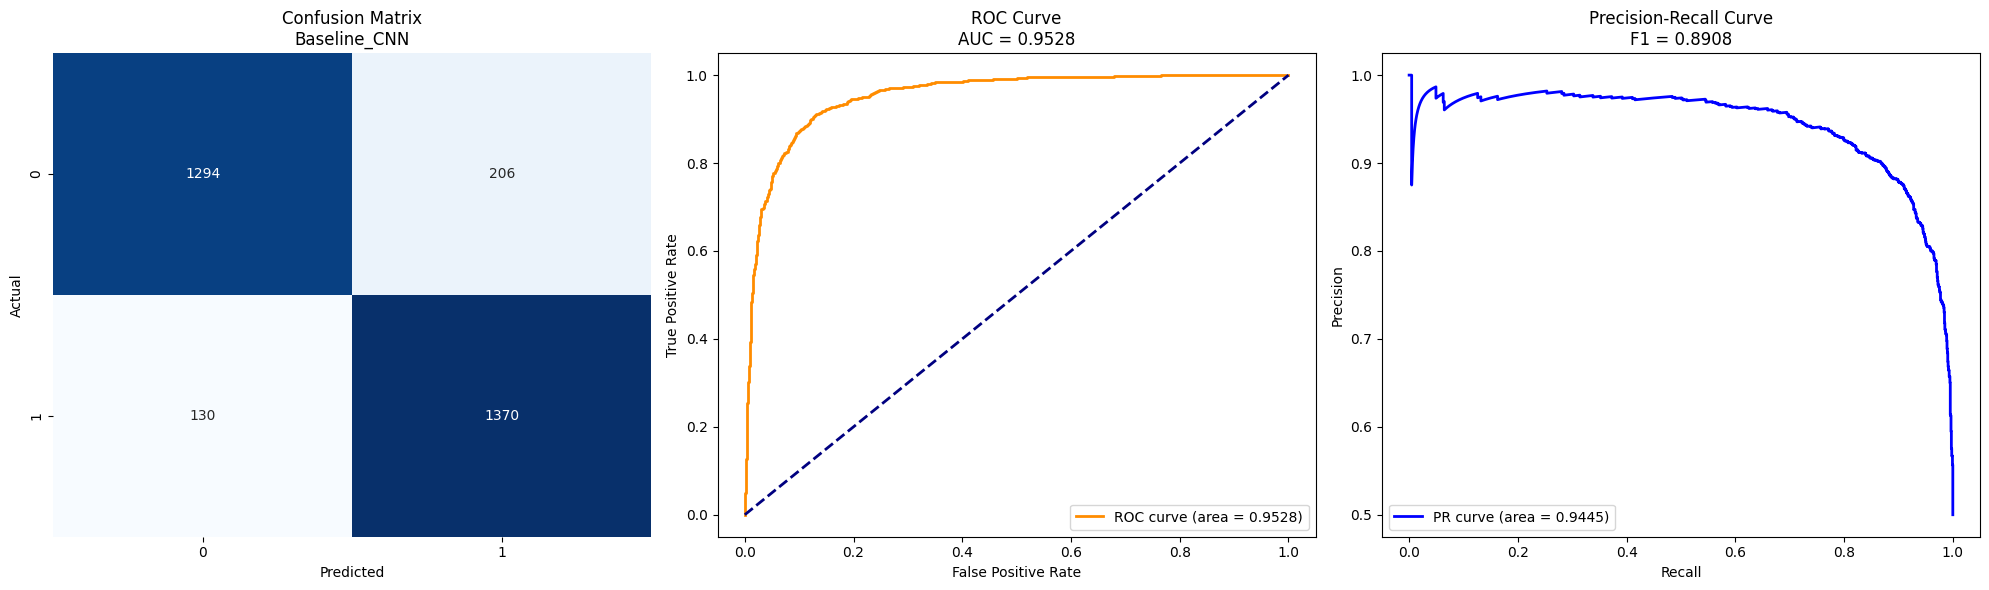

Đã lưu biểu đồ đánh giá vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4/plot_metrics_Baseline_CNN.png
Đang lưu model vào /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4...
Đã lưu model hoàn chỉnh vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4/model_Baseline_CNN.keras
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

--- Bắt đầu Thí nghiệm cho: MobileNetV2_HPF_Enabled (Scenario: scenario_openstego_png_0.4) ---
--- Giai đoạn 1 (Frozen) cho MobileNetV2_HPF_Enabled (LR=0.0001) ---
Epoch 1/20
438/438 - 72s - 164ms/step - accuracy: 0.5380 - auc: 0.5538 - loss: 0.8292 - precision: 0.5391 - recall: 0.5202 - val_accuracy: 0.6253 - val_auc: 0.6652 - val_loss: 0.6652 - val_precision: 0.6204 - val_recall: 0.6460
Epoch 2/20
438/438 - 31s - 70ms/step - accuracy: 0.5885 - auc: 0.6243 - loss: 0.7465 - precision: 0.5900 - recall: 0.5814 - val_accuracy: 0.6867 - val_auc: 0.7439 - val_loss: 0.6167 - val_precision: 0.6797 - val_recall:

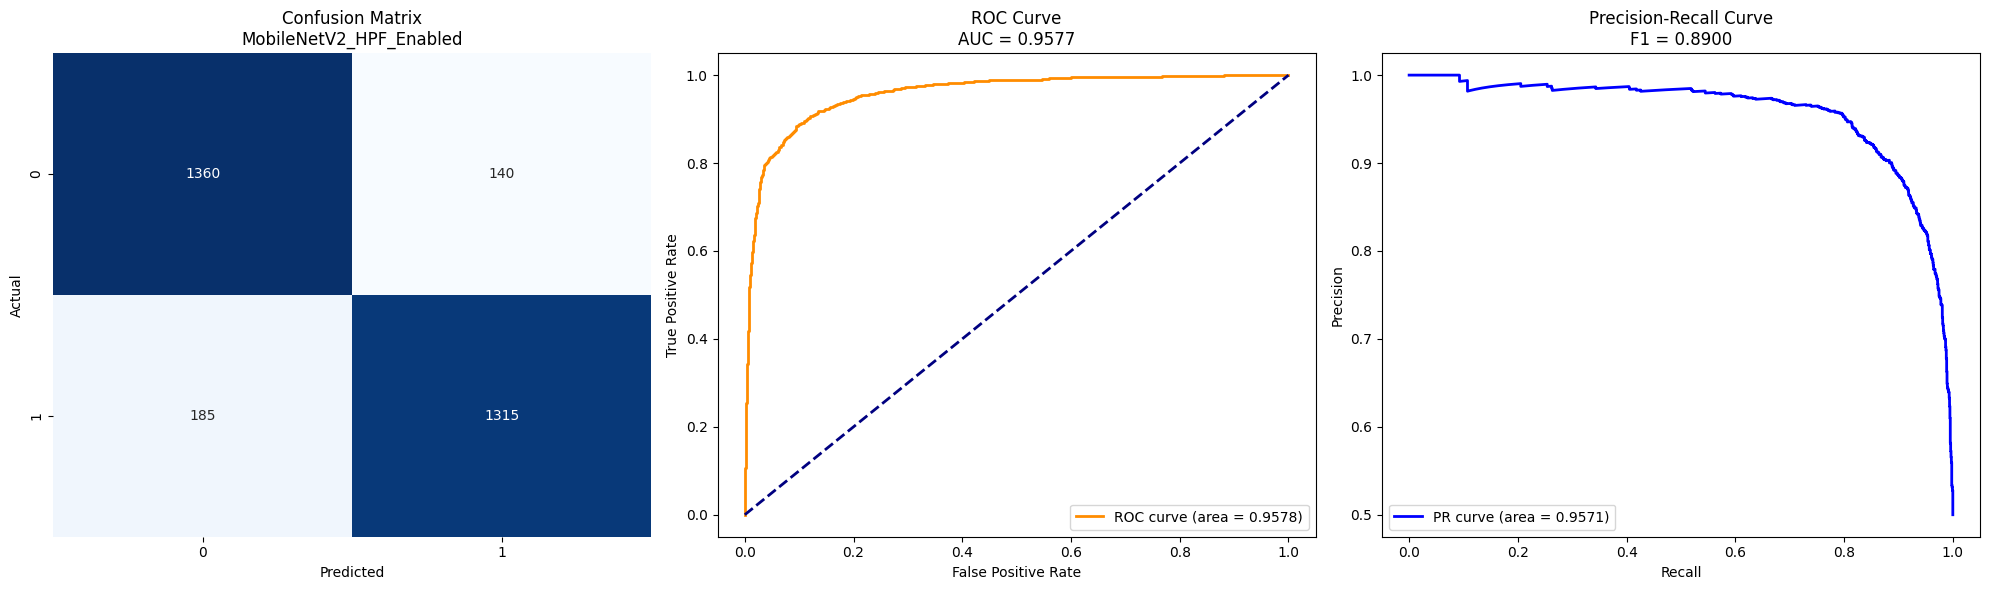

Đã lưu biểu đồ đánh giá vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4/plot_metrics_MobileNetV2_HPF_Enabled.png
Đang lưu model vào /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4...
Đã lưu model hoàn chỉnh vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4/model_MobileNetV2_HPF_Enabled.keras

--- Bắt đầu Thí nghiệm cho: MobileNetV2_HPF_Disabled (Scenario: scenario_openstego_png_0.4) ---
--- Giai đoạn 1 (Frozen) cho MobileNetV2_HPF_Disabled (LR=0.0001) ---
Epoch 1/20
438/438 - 42s - 97ms/step - accuracy: 0.5118 - auc: 0.5206 - loss: 0.8306 - precision: 0.5119 - recall: 0.5140 - val_accuracy: 0.5660 - val_auc: 0.5941 - val_loss: 0.6956 - val_precision: 0.5713 - val_recall: 0.5287
Epoch 2/20
438/438 - 23s - 53ms/step - accuracy: 0.5694 - auc: 0.6014 - loss: 0.7408 - precision: 0.5703 - recall: 0.5634 - val_accuracy: 0.6320 - val_auc: 0.6864 - val_loss: 0.6492 - val_precision: 0.6263 - val_recall: 0.6547
Epoch 3/20
438/438

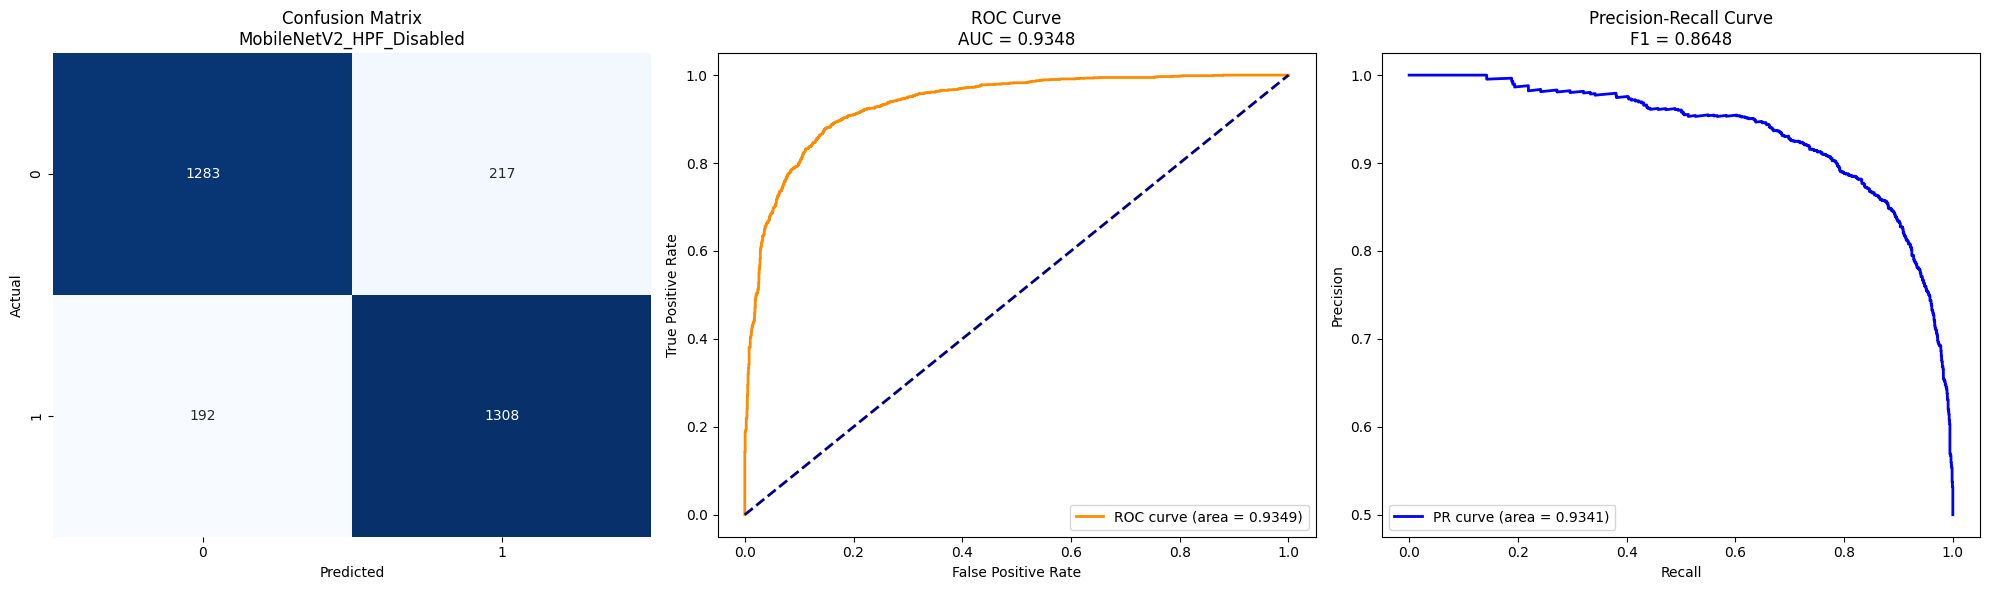

Đã lưu biểu đồ đánh giá vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4/plot_metrics_MobileNetV2_HPF_Disabled.png
Đang lưu model vào /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4...
Đã lưu model hoàn chỉnh vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4/model_MobileNetV2_HPF_Disabled.keras
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

--- Bắt đầu Thí nghiệm cho: VGG16_HPF_Enabled (Scenario: scenario_openstego_png_0.4) ---
--- Giai đoạn 1 (Frozen) cho VGG16_HPF_Enabled (LR=0.0001) ---
Epoch 1/20
438/438 - 218s - 497ms/step - accuracy: 0.5186 - auc: 0.5378 - loss: 0.7444 - precision: 0.5178 - recall: 0.5338 - val_accuracy: 0.6150 - val_auc: 0.6875 - val_loss: 0.6669 - val_precision: 0.6693 - val_recall: 0.4547
Epoch 2/20
438/438 - 161s - 367ms/step - accuracy: 0.5584 - auc: 0.5937 - loss: 0.6918 - precision: 0.5653 - recall: 0.5067 - val_accuracy: 0.6953 - val_auc: 0.7623 - val_loss: 0.6470 - val_precision: 0.7

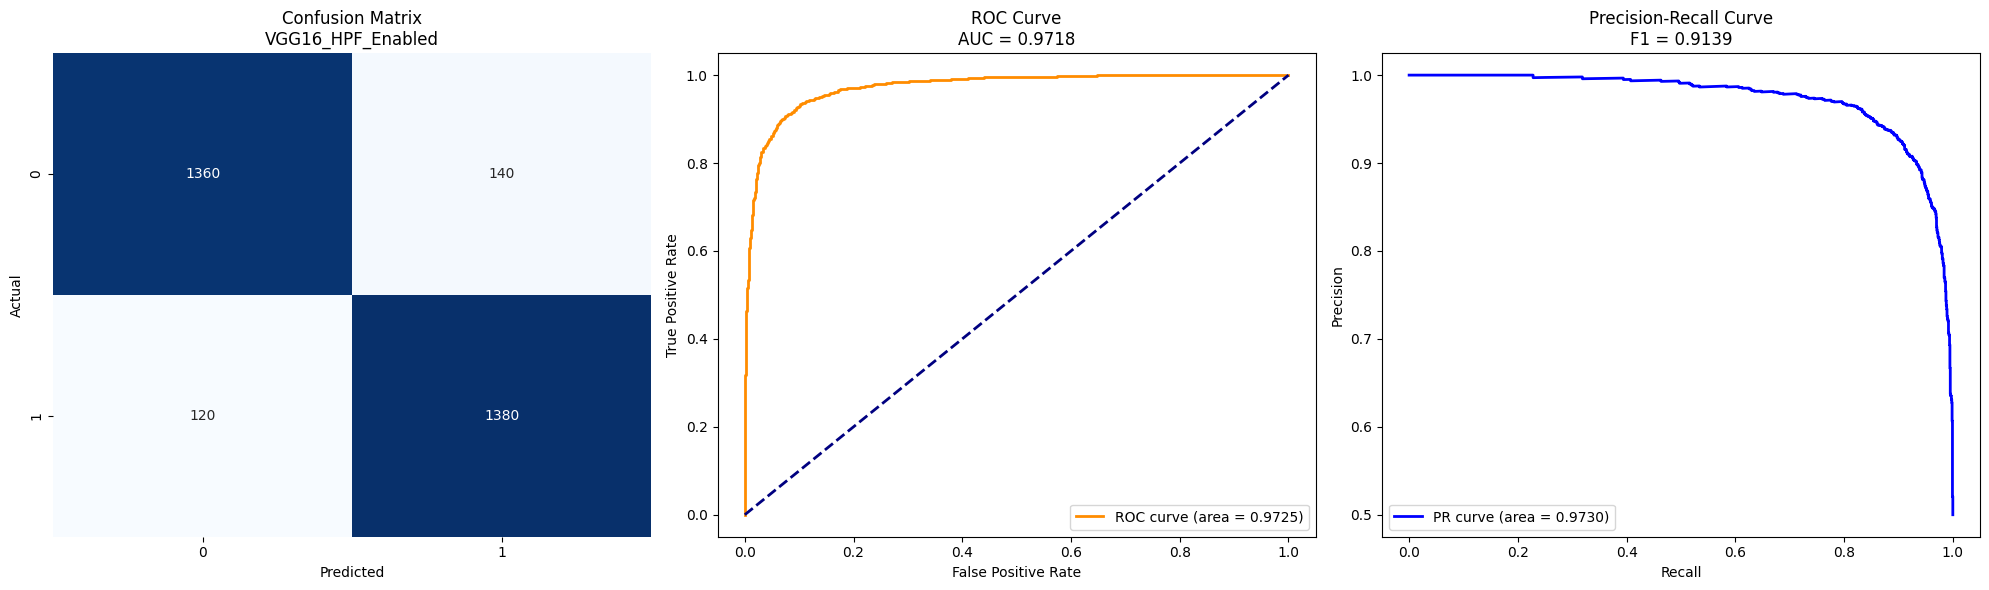

Đã lưu biểu đồ đánh giá vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4/plot_metrics_VGG16_HPF_Enabled.png
Đang lưu model vào /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4...
Đã lưu model hoàn chỉnh vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4/model_VGG16_HPF_Enabled.keras
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

--- Bắt đầu Thí nghiệm cho: ResNet50_HPF_Enabled (Scenario: scenario_openstego_png_0.4) ---
--- Giai đoạn 1 (Frozen) cho ResNet50_HPF_Enabled (LR=0.0001) ---
Epoch 1/20
438/438 - 111s - 254ms/step - accuracy: 0.5114 - auc: 0.5138 - loss: 0.7503 - precision: 0.5117 - recall: 0.4954 - val_accuracy: 0.5860 - val_auc: 0.6159 - val_loss: 0.6779 - val_precision: 0.5744 - val_recall: 0.6640
Epoch 2/20
438/438 - 82s - 187ms/step - accuracy: 0.5547 - auc: 0.5789 - loss: 0.6941 - precision: 0.5531 - recall: 0.5677 - val_accuracy: 0.6203 - val_auc: 0.6935 - val_loss: 0.6597 - val_precision: 0.5944 - val

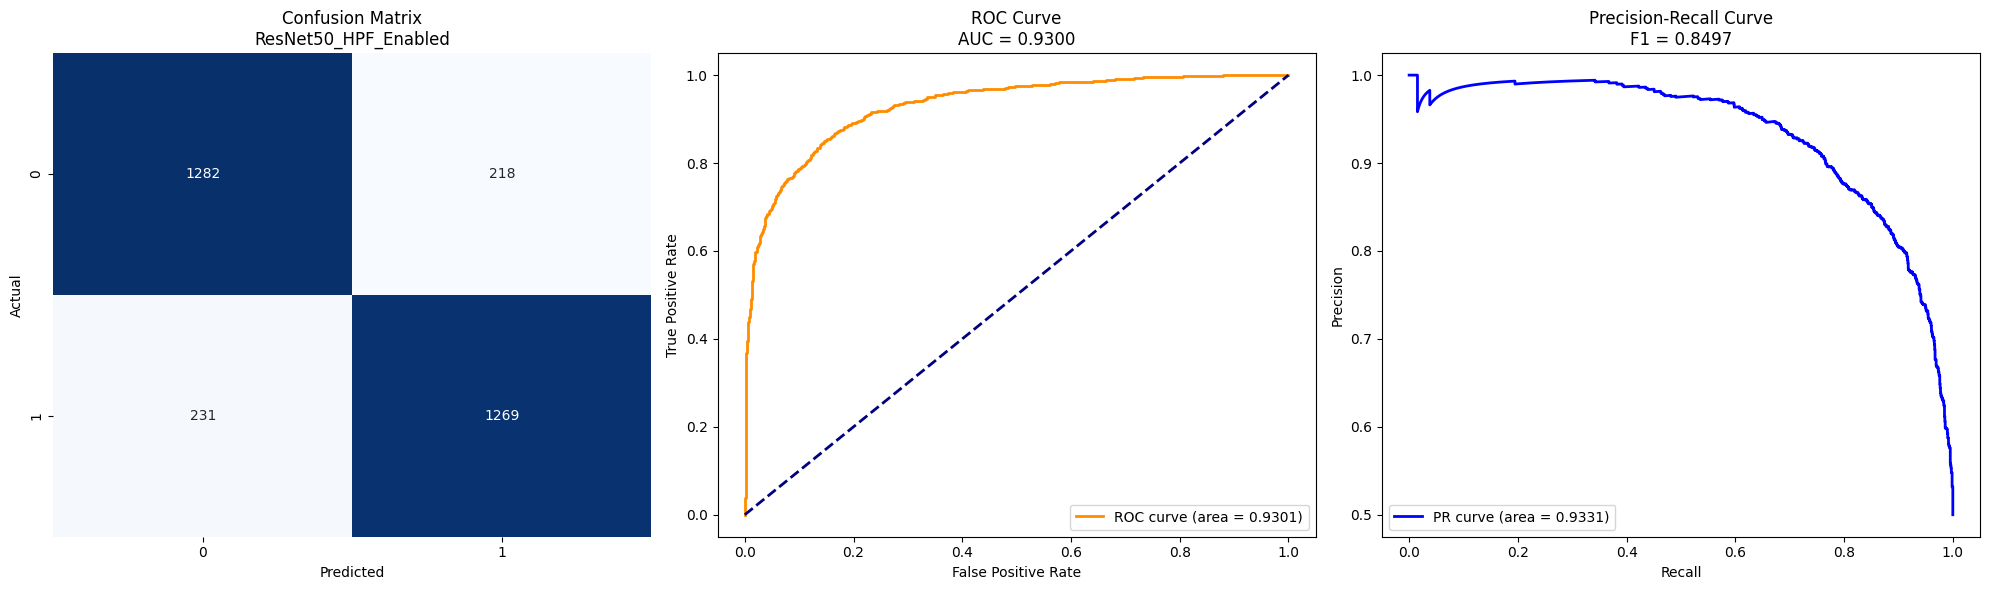

Đã lưu biểu đồ đánh giá vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4/plot_metrics_ResNet50_HPF_Enabled.png
Đang lưu model vào /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4...
Đã lưu model hoàn chỉnh vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4/model_ResNet50_HPF_Enabled.keras

--- KẾT QUẢ TỔNG HỢP (PHẦN 7.1: 0.4 BPP) ---
                                                 acc       auc  precision  \
scenario          model                                                     
openstego_png_0.4 Baseline_CNN              0.888000  0.952787   0.869289   
                  MobileNetV2_HPF_Enabled   0.891667  0.957721   0.903780   
                  MobileNetV2_HPF_Disabled  0.863667  0.934798   0.857705   
                  VGG16_HPF_Enabled         0.913333  0.971786   0.907895   
                  ResNet50_HPF_Enabled      0.850333  0.930013   0.853396   

                                              recall       

In [ ]:
print("=== BẮT ĐẦU PHẦN 7.1: HUẤN LUYỆN KỊCH BẢN 0.4 BPP ===")

# Chọn các kịch bản 0.4 bpp
scenarios_to_run = [
    # 'steghide_jpg_0.4',
    'openstego_png_0.4'
]

# Khuyến nghị dùng BATCH_SIZE=32 cho cân bằng
HYPERPARAMS = {
    'batch_size': 32,
    'initial_lr': 1e-4,
    'finetune_lr': 1e-5
}

# Danh sách model cần chạy
model_builders = {
    "Baseline_CNN": run_baseline_experiment,
    "MobileNetV2_HPF_Enabled": lambda scenario_dir, bs: run_experiment(build_model_mobilenetv2, scenario_dir, HYPERPARAMS, use_hpf=True),
    "MobileNetV2_HPF_Disabled": lambda scenario_dir, bs: run_experiment(build_model_mobilenetv2, scenario_dir, HYPERPARAMS, use_hpf=False),
    "VGG16_HPF_Enabled": lambda scenario_dir, bs: run_experiment(build_model_vgg16, scenario_dir, HYPERPARAMS, use_hpf=True),
    "ResNet50_HPF_Enabled": lambda scenario_dir, bs: run_experiment(build_model_resnet50, scenario_dir, HYPERPARAMS, use_hpf=True)
}

results_0_4 = []

for key in scenarios_to_run:
    if key not in scenario_dirs_all:
        print(f"Bỏ qua {key}, không tìm thấy thư mục (hãy chạy Step 5).")
        continue

    scenario_dir = scenario_dirs_all[key]
    print(f'\n======================================================')
    print(f' BẮT ĐẦU SO SÁNH TRÊN KỊCH BẢN: {key}')
    print(f'======================================================')

    for model_name, train_function in model_builders.items():
        model_eval_metrics = train_function(scenario_dir, HYPERPARAMS['batch_size'])

        # Thêm thông tin vào kết quả
        model_eval_metrics['model'] = model_name
        model_eval_metrics['scenario'] = key
        results_0_4.append(model_eval_metrics)

# In kết quả
df_results_0_4 = pd.DataFrame(results_0_4)
df_results_0_4 = df_results_0_4.set_index(['scenario', 'model'])
print("\n--- KẾT QUẢ TỔNG HỢP (PHẦN 7.1: 0.4 BPP) ---")
print(df_results_0_4)

csv_path = os.path.join(base_dir, 'results_final_0_4_bpp.csv')
df_results_0_4.to_csv(csv_path)
print(f"Đã lưu kết quả vào {csv_path}")

### Step 7.2 (Phiên 2: 0.2 bpp)


=== BẮT ĐẦU PHẦN 7.2: HUẤN LUYỆN KỊCH BẢN 0.2 BPP ===

 BẮT ĐẦU SO SÁNH TRÊN KỊCH BẢN: openstego_png_0.2

--- Bắt đầu Thí nghiệm cho: Baseline_CNN ---
Epoch 1/20
438/438 - 43s - 98ms/step - accuracy: 0.8249 - auc: 0.8991 - loss: 0.4768 - precision: 0.8016 - recall: 0.8636 - val_accuracy: 0.8480 - val_auc: 0.9244 - val_loss: 0.4344 - val_precision: 0.8489 - val_recall: 0.8467
Epoch 2/20
438/438 - 28s - 63ms/step - accuracy: 0.8562 - auc: 0.9255 - loss: 0.4342 - precision: 0.8471 - recall: 0.8691 - val_accuracy: 0.8543 - val_auc: 0.9309 - val_loss: 0.4242 - val_precision: 0.8633 - val_recall: 0.8420
Epoch 3/20
438/438 - 43s - 98ms/step - accuracy: 0.8674 - auc: 0.9357 - loss: 0.4171 - precision: 0.8612 - recall: 0.8762 - val_accuracy: 0.8630 - val_auc: 0.9360 - val_loss: 0.4151 - val_precision: 0.8637 - val_recall: 0.8620
Epoch 4/20
438/438 - 28s - 63ms/step - accuracy: 0.8756 - auc: 0.9431 - loss: 0.4039 - precision: 0.8676 - recall: 0.8861 - val_accuracy: 0.8720 - val_auc: 0.9427 - val

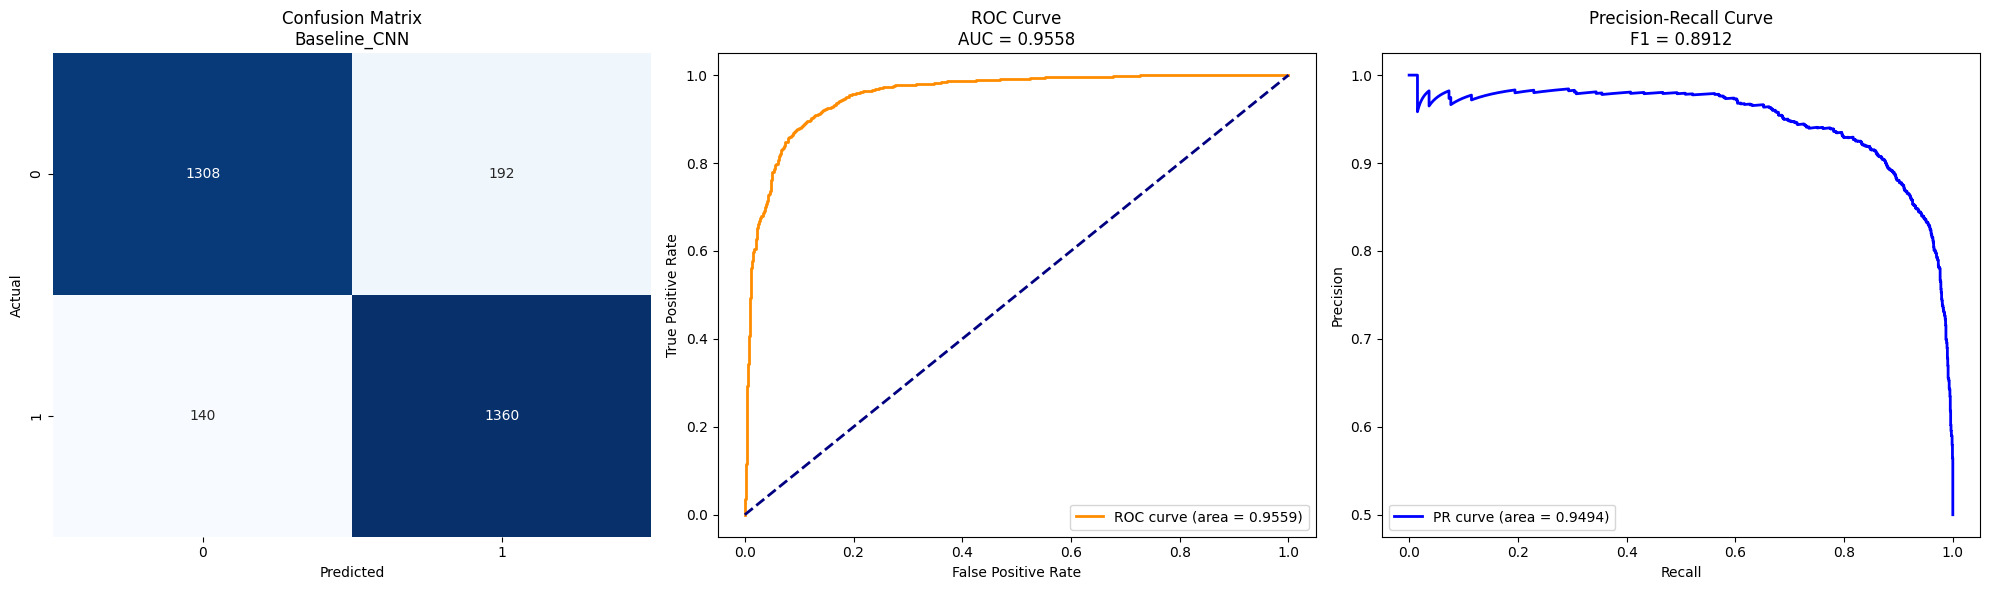

Đã lưu biểu đồ đánh giá vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.2/plot_metrics_Baseline_CNN.png
Đang lưu model vào /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.2...
Đã lưu model hoàn chỉnh vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.2/model_Baseline_CNN.keras
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

--- Bắt đầu Thí nghiệm cho: MobileNetV2_HPF_Enabled (Scenario: scenario_openstego_png_0.2) ---
--- Giai đoạn 1 (Frozen) cho MobileNetV2_HPF_Enabled (LR=0.0001) ---
Epoch 1/20
438/438 - 74s - 169ms/step - accuracy: 0.5523 - auc: 0.5750 - loss: 0.8076 - precision: 0.5547 - recall: 0.5307 - val_accuracy: 0.6480 - val_auc: 0.7005 - val_loss: 0.6428 - val_precision: 0.6447 - val_recall: 0.6593
Epoch 2/20
438/438 - 31s - 71ms/step - accuracy: 0.5957 - auc: 0.6366 - loss: 0.7372 - precision: 0.5950 - recall: 0.5992 - val_accuracy: 0.6810 - val_auc: 0.7545 - val_loss: 0.6137 - val_precision: 0.7153 - val_recall:

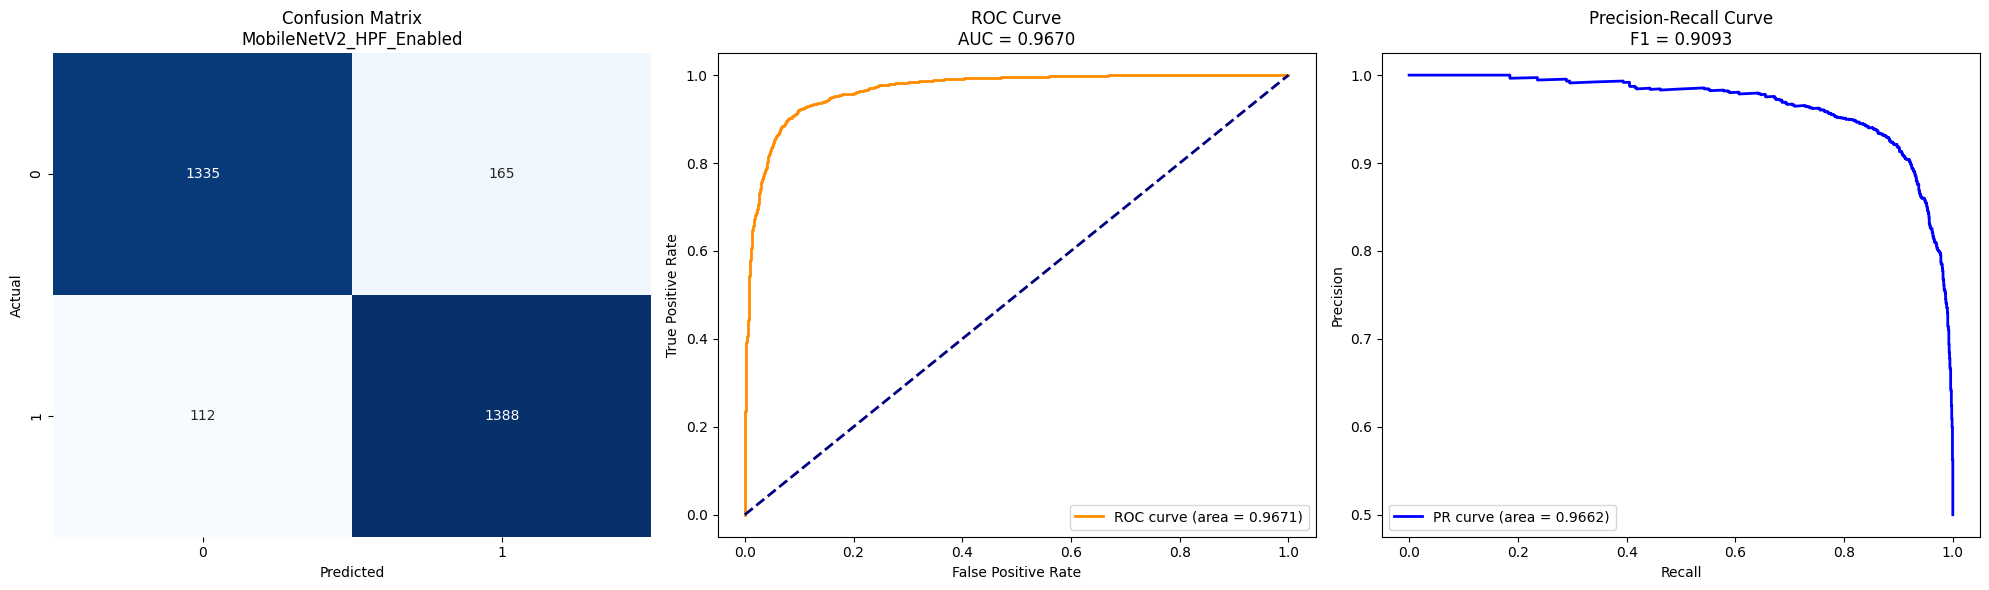

Đã lưu biểu đồ đánh giá vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.2/plot_metrics_MobileNetV2_HPF_Enabled.png
Đang lưu model vào /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.2...
Đã lưu model hoàn chỉnh vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.2/model_MobileNetV2_HPF_Enabled.keras

--- Bắt đầu Thí nghiệm cho: MobileNetV2_HPF_Disabled (Scenario: scenario_openstego_png_0.2) ---
--- Giai đoạn 1 (Frozen) cho MobileNetV2_HPF_Disabled (LR=0.0001) ---
Epoch 1/20
438/438 - 42s - 96ms/step - accuracy: 0.5357 - auc: 0.5502 - loss: 0.8011 - precision: 0.5350 - recall: 0.5454 - val_accuracy: 0.6127 - val_auc: 0.6493 - val_loss: 0.6684 - val_precision: 0.6190 - val_recall: 0.5860
Epoch 2/20
438/438 - 23s - 53ms/step - accuracy: 0.5721 - auc: 0.6018 - loss: 0.7446 - precision: 0.5707 - recall: 0.5808 - val_accuracy: 0.6667 - val_auc: 0.7193 - val_loss: 0.6336 - val_precision: 0.6768 - val_recall: 0.6380
Epoch 3/20
438/438

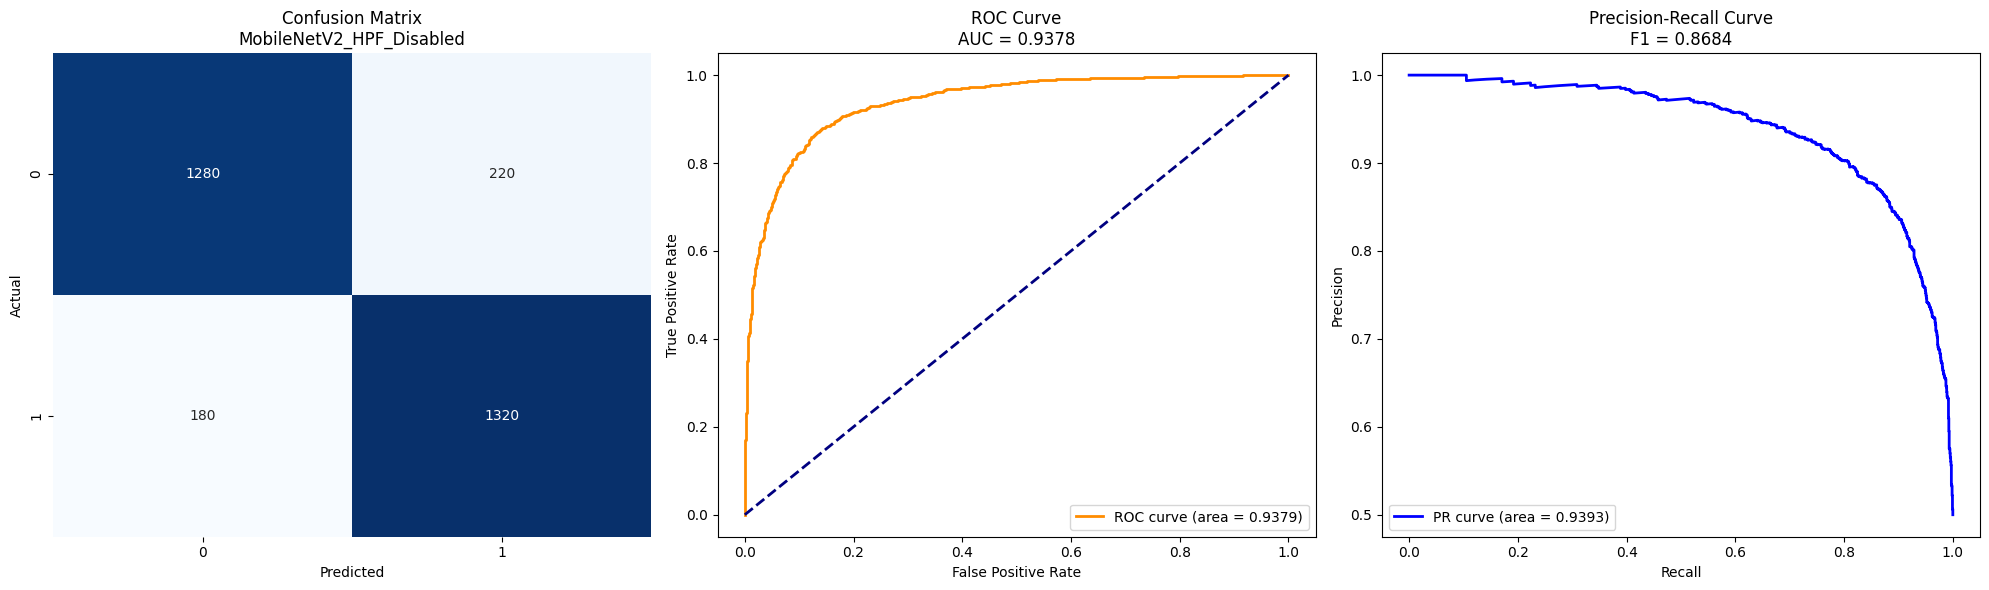

Đã lưu biểu đồ đánh giá vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.2/plot_metrics_MobileNetV2_HPF_Disabled.png
Đang lưu model vào /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.2...
Đã lưu model hoàn chỉnh vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.2/model_MobileNetV2_HPF_Disabled.keras
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

--- Bắt đầu Thí nghiệm cho: VGG16_HPF_Enabled (Scenario: scenario_openstego_png_0.2) ---
--- Giai đoạn 1 (Frozen) cho VGG16_HPF_Enabled (LR=0.0001) ---
Epoch 1/20
438/438 - 238s - 542ms/step - accuracy: 0.5205 - auc: 0.5366 - loss: 0.7660 - precision: 0.5214 - recall: 0.4975 - val_accuracy: 0.6833 - val_auc: 0.7490 - val_loss: 0.6599 - val_precision: 0.7010 - val_recall: 0.6393
Epoch 2/20
438/438 - 175s - 399ms/step - accuracy: 0.5594 - auc: 0.6036 - loss: 0.6910 - precision: 0.5595 - recall: 0.5560 - val_accuracy: 0.7483 - val_auc: 0.8257 - val_loss: 0.6278 - val_precision: 0.7

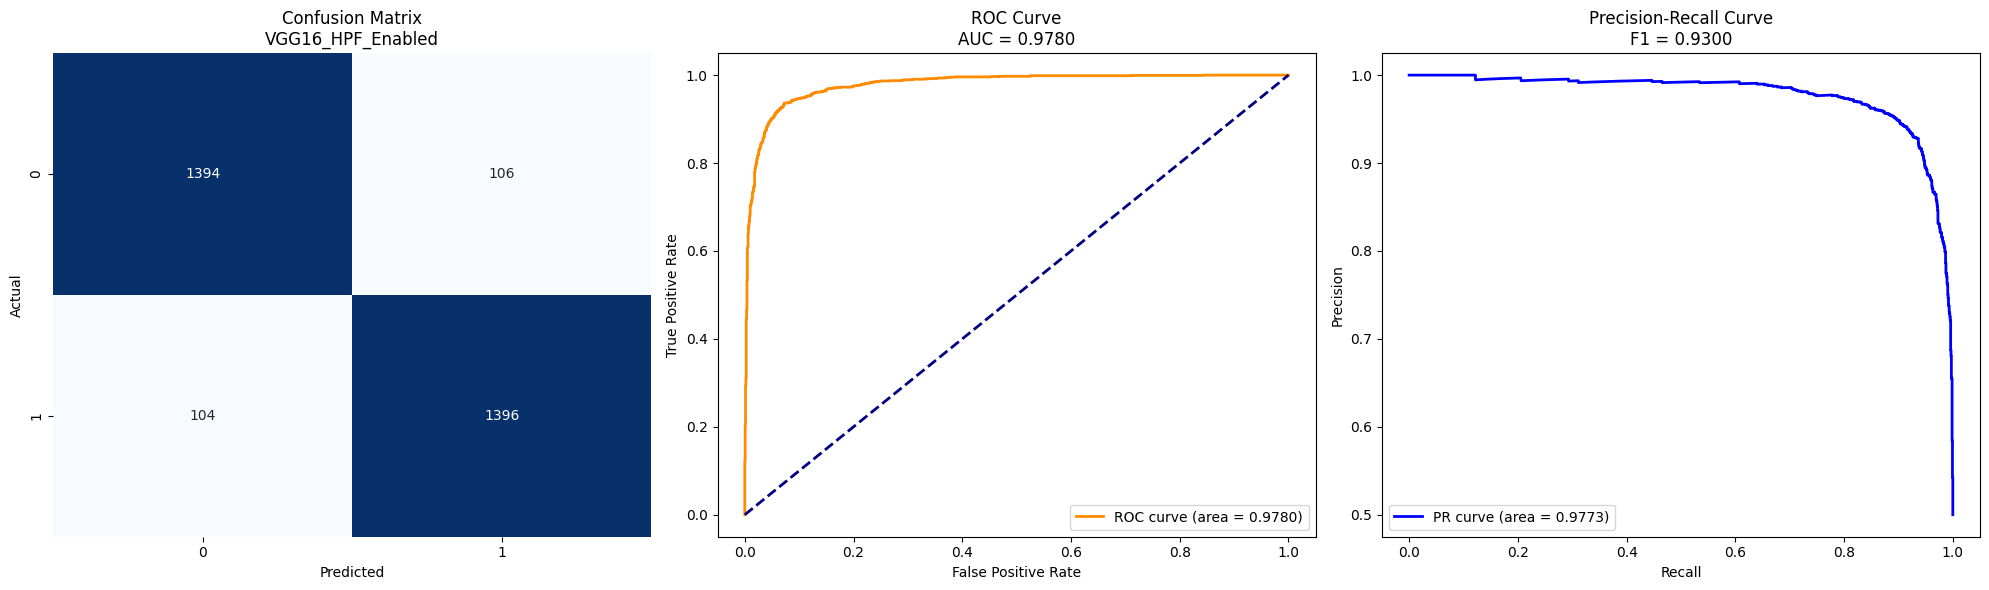

Đã lưu biểu đồ đánh giá vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.2/plot_metrics_VGG16_HPF_Enabled.png
Đang lưu model vào /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.2...
Đã lưu model hoàn chỉnh vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.2/model_VGG16_HPF_Enabled.keras
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

--- Bắt đầu Thí nghiệm cho: ResNet50_HPF_Enabled (Scenario: scenario_openstego_png_0.2) ---
--- Giai đoạn 1 (Frozen) cho ResNet50_HPF_Enabled (LR=0.0001) ---
Epoch 1/20
438/438 - 120s - 274ms/step - accuracy: 0.5290 - auc: 0.5392 - loss: 0.7572 - precision: 0.5290 - recall: 0.5289 - val_accuracy: 0.6110 - val_auc: 0.6558 - val_loss: 0.6676 - val_precision: 0.5986 - val_recall: 0.6740
Epoch 2/20
438/438 - 88s - 201ms/step - accuracy: 0.5732 - auc: 0.6018 - loss: 0.6890 - precision: 0.5720 - recall: 0.5831 - val_accuracy: 0.6503 - val_auc: 0.7013 - val_loss: 0.6553 - val_precision: 0.6531 - val

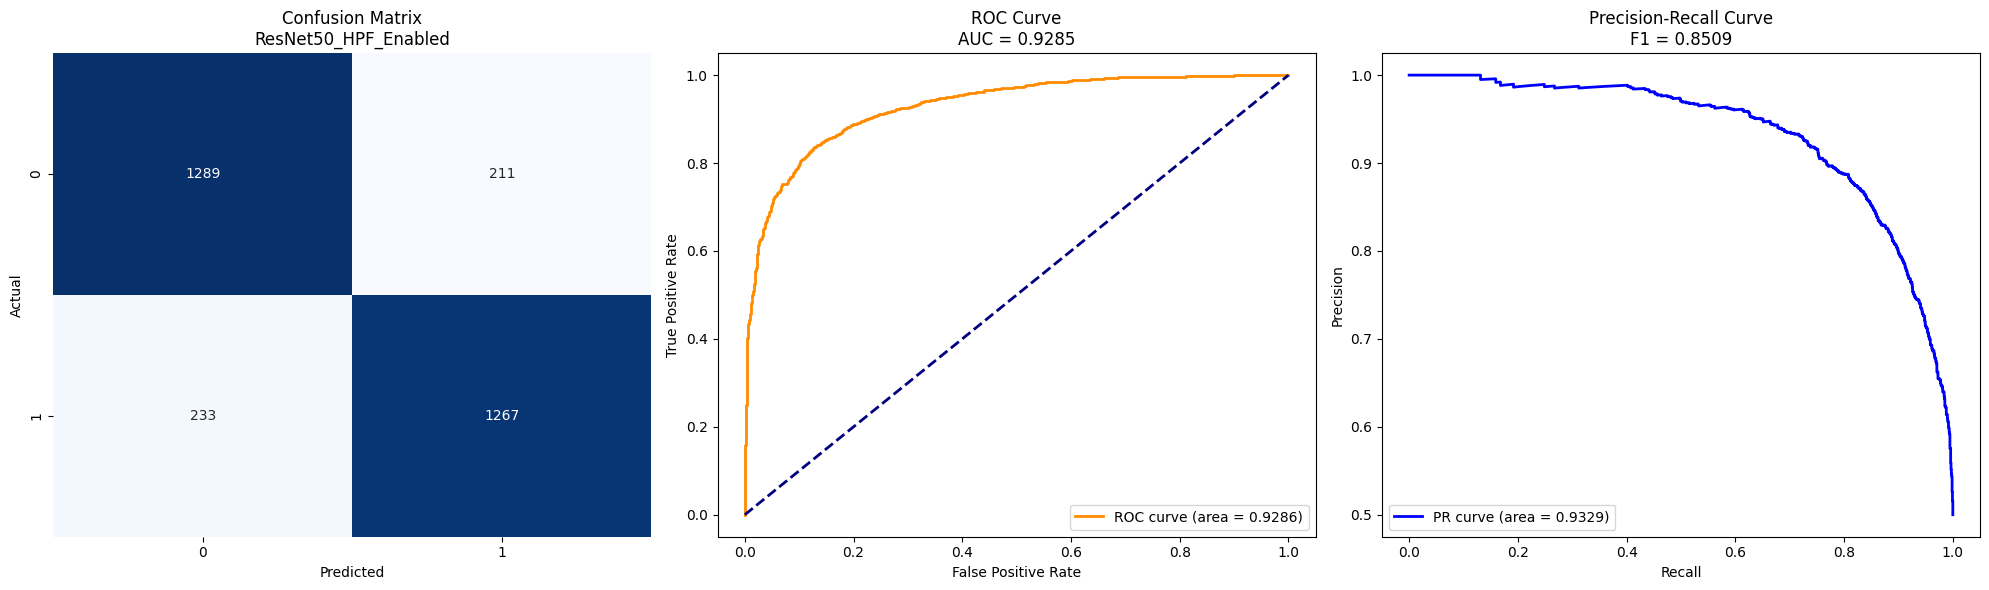

Đã lưu biểu đồ đánh giá vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.2/plot_metrics_ResNet50_HPF_Enabled.png
Đang lưu model vào /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.2...
Đã lưu model hoàn chỉnh vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.2/model_ResNet50_HPF_Enabled.keras

--- KẾT QUẢ TỔNG HỢP (PHẦN 7.2: 0.2 BPP) ---
                                                 acc       auc  precision  \
scenario          model                                                     
openstego_png_0.2 Baseline_CNN              0.889333  0.955840   0.876289   
                  MobileNetV2_HPF_Enabled   0.907667  0.966968   0.893754   
                  MobileNetV2_HPF_Disabled  0.866667  0.937790   0.857143   
                  VGG16_HPF_Enabled         0.930000  0.978032   0.929427   
                  ResNet50_HPF_Enabled      0.852000  0.928532   0.857240   

                                              recall       

In [ ]:
print("=== BẮT ĐẦU PHẦN 7.2: HUẤN LUYỆN KỊCH BẢN 0.2 BPP ===")

# Chọn các kịch bản 0.2 bpp
scenarios_to_run = [
    # 'steghide_jpg_0.2',
    'openstego_png_0.2'
]

# Khuyến nghị dùng BATCH_SIZE=32 cho cân bằng
HYPERPARAMS = {
    'batch_size': 32,
    'initial_lr': 1e-4,
    'finetune_lr': 1e-5
}

# Danh sách model cần chạy
model_builders = {
    "Baseline_CNN": run_baseline_experiment,
    "MobileNetV2_HPF_Enabled": lambda scenario_dir, bs: run_experiment(build_model_mobilenetv2, scenario_dir, HYPERPARAMS, use_hpf=True),
    "MobileNetV2_HPF_Disabled": lambda scenario_dir, bs: run_experiment(build_model_mobilenetv2, scenario_dir, HYPERPARAMS, use_hpf=False),
    "VGG16_HPF_Enabled": lambda scenario_dir, bs: run_experiment(build_model_vgg16, scenario_dir, HYPERPARAMS, use_hpf=True),
    "ResNet50_HPF_Enabled": lambda scenario_dir, bs: run_experiment(build_model_resnet50, scenario_dir, HYPERPARAMS, use_hpf=True)
}

results_0_2 = []

for key in scenarios_to_run:
    if key not in scenario_dirs_all:
        print(f"Bỏ qua {key}, không tìm thấy thư mục (hãy chạy Step 5).")
        continue

    scenario_dir = scenario_dirs_all[key]
    print(f'\n======================================================')
    print(f' BẮT ĐẦU SO SÁNH TRÊN KỊCH BẢN: {key}')
    print(f'======================================================')

    for model_name, train_function in model_builders.items():
        model_eval_metrics = train_function(scenario_dir, HYPERPARAMS['batch_size'])

        # Thêm thông tin vào kết quả
        model_eval_metrics['model'] = model_name
        model_eval_metrics['scenario'] = key
        results_0_2.append(model_eval_metrics)

# In kết quả
df_results_0_2 = pd.DataFrame(results_0_2)
df_results_0_2 = df_results_0_2.set_index(['scenario', 'model'])
print("\n--- KẾT QUẢ TỔNG HỢP (PHẦN 7.2: 0.2 BPP) ---")
print(df_results_0_2)

csv_path = os.path.join(base_dir, 'results_final_0_2_bpp.csv')
df_results_0_2.to_csv(csv_path)
print(f"Đã lưu kết quả vào {csv_path}")

### Step 7.3 (Phiên 3: 0.1 bpp)


=== BẮT ĐẦU PHẦN 7.3: HUẤN LUYỆN KỊCH BẢN 0.1 BPP ===

 BẮT ĐẦU SO SÁNH TRÊN KỊCH BẢN: openstego_png_0.1

--- Bắt đầu Thí nghiệm cho: Baseline_CNN ---
Epoch 1/20
438/438 - 85s - 195ms/step - accuracy: 0.8186 - auc: 0.8998 - loss: 0.4771 - precision: 0.7941 - recall: 0.8605 - val_accuracy: 0.8613 - val_auc: 0.9385 - val_loss: 0.4195 - val_precision: 0.8465 - val_recall: 0.8827
Epoch 2/20
438/438 - 27s - 61ms/step - accuracy: 0.8555 - auc: 0.9249 - loss: 0.4351 - precision: 0.8491 - recall: 0.8646 - val_accuracy: 0.8720 - val_auc: 0.9452 - val_loss: 0.4014 - val_precision: 0.8661 - val_recall: 0.8800
Epoch 3/20
438/438 - 27s - 61ms/step - accuracy: 0.8639 - auc: 0.9336 - loss: 0.4209 - precision: 0.8602 - recall: 0.8692 - val_accuracy: 0.8830 - val_auc: 0.9512 - val_loss: 0.3940 - val_precision: 0.9049 - val_recall: 0.8560
Epoch 4/20
438/438 - 27s - 62ms/step - accuracy: 0.8751 - auc: 0.9421 - loss: 0.4051 - precision: 0.8727 - recall: 0.8781 - val_accuracy: 0.8783 - val_auc: 0.9536 - va

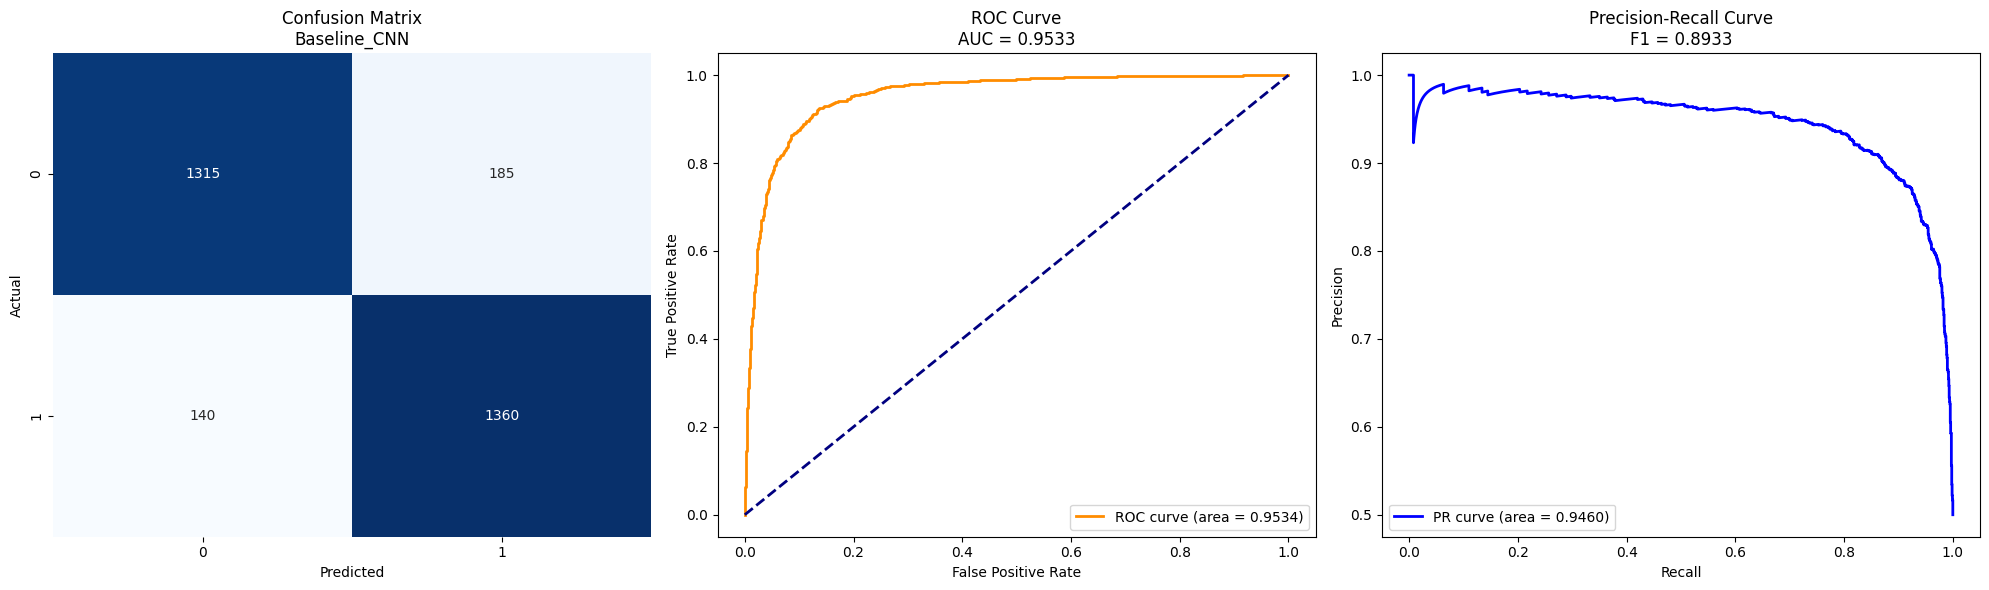

Đã lưu biểu đồ đánh giá vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.1/plot_metrics_Baseline_CNN.png
Đang lưu model vào /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.1...
Đã lưu model hoàn chỉnh vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.1/model_Baseline_CNN.keras
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Bắt đầu Thí nghiệm cho: MobileNetV2_HPF_Enabled (Scenario: scenario_openstego_png_0.1) ---
--- Giai đoạn 1 (Frozen) cho MobileNetV2_HPF_Enabled (LR=0.0001) ---
Epoch 1/20
438/438 - 73s - 166ms/step - accuracy: 0.5042 - auc: 0.5096 - loss: 0.8737 - precision: 0.5041 - recall: 0.4912 - val_accuracy: 0.5550 - val_auc: 0.5735 - val_loss: 0.7047 - val_precision: 0.5559 - val_recall: 0.5467
Epoch 2/20
438/438 - 31s - 71ms/step - accuracy: 0.5437 - auc: 0.5578 - loss: 0.8051 - precision: 0.5441 - recall: 0.5406 - val_accuracy: 0.6153 - val_auc: 0.6562 - val_loss: 0.6627 - val_precision: 0.6167 - val_recall:

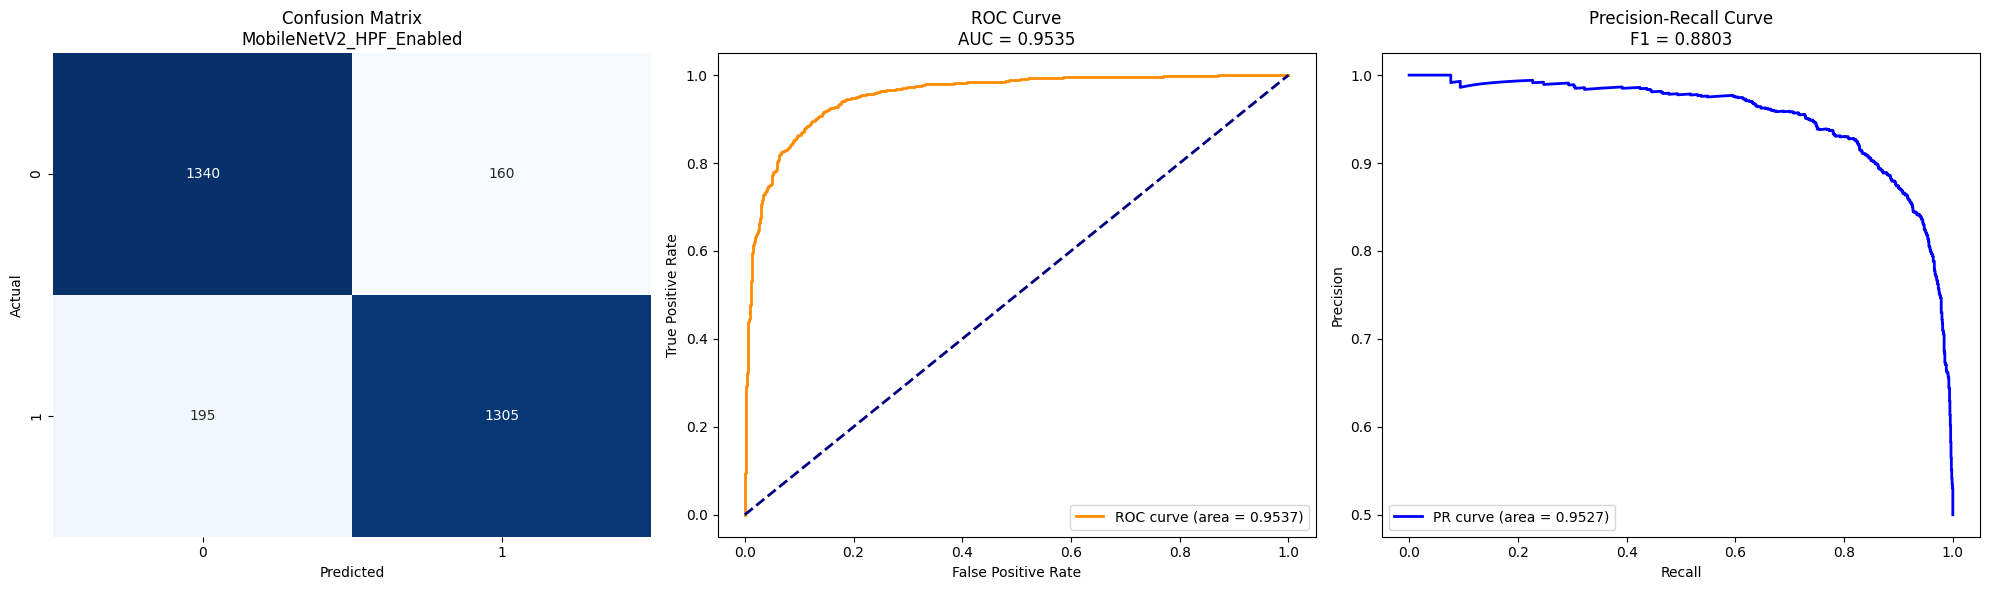

Đã lưu biểu đồ đánh giá vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.1/plot_metrics_MobileNetV2_HPF_Enabled.png
Đang lưu model vào /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.1...
Đã lưu model hoàn chỉnh vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.1/model_MobileNetV2_HPF_Enabled.keras

--- Bắt đầu Thí nghiệm cho: MobileNetV2_HPF_Disabled (Scenario: scenario_openstego_png_0.1) ---
--- Giai đoạn 1 (Frozen) cho MobileNetV2_HPF_Disabled (LR=0.0001) ---
Epoch 1/20
438/438 - 41s - 94ms/step - accuracy: 0.5219 - auc: 0.5302 - loss: 0.8207 - precision: 0.5221 - recall: 0.5149 - val_accuracy: 0.5767 - val_auc: 0.6047 - val_loss: 0.6898 - val_precision: 0.5786 - val_recall: 0.5647
Epoch 2/20
438/438 - 22s - 50ms/step - accuracy: 0.5621 - auc: 0.5849 - loss: 0.7568 - precision: 0.5624 - recall: 0.5613 - val_accuracy: 0.6453 - val_auc: 0.6931 - val_loss: 0.6464 - val_precision: 0.6546 - val_recall: 0.6153
Epoch 3/20
438/438

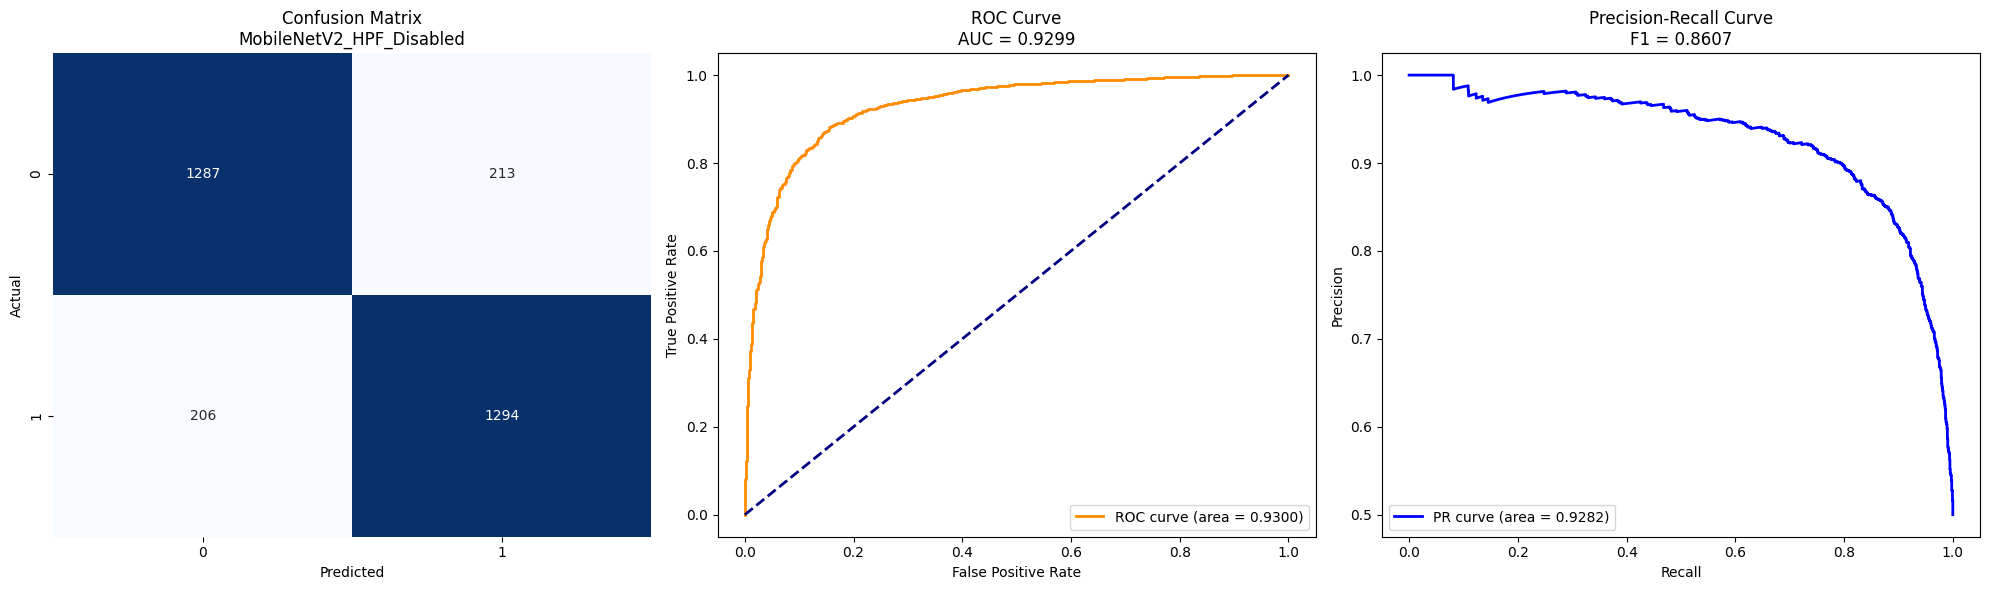

Đã lưu biểu đồ đánh giá vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.1/plot_metrics_MobileNetV2_HPF_Disabled.png
Đang lưu model vào /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.1...
Đã lưu model hoàn chỉnh vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.1/model_MobileNetV2_HPF_Disabled.keras
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Bắt đầu Thí nghiệm cho: VGG16_HPF_Enabled (Scenario: scenario_openstego_png_0.1) ---
--- Giai đoạn 1 (Frozen) cho VGG16_HPF_Enabled (LR=0.0001) ---
Epoch 1/20
438/438 - 241s - 551ms/step - accuracy: 0.4921 - auc: 0.4854 - loss: 0.8272 - precision: 0.4906 - recall: 0.4233 - val_accuracy: 0.4943 - val_auc: 0.4885 - val_loss: 0.7031 - val_precision: 0.4927 - val_recall: 0.3807
Epoch 2/20
438/438 - 181s - 414ms/step - accuracy: 0.5170 - auc: 0.5210 - loss: 0.7434 - precision: 0.5175 - recall: 0.5123 - val_accuracy: 0.6060 - val_auc: 0.6375 - val_loss: 0.6773 - val_precision: 0.6

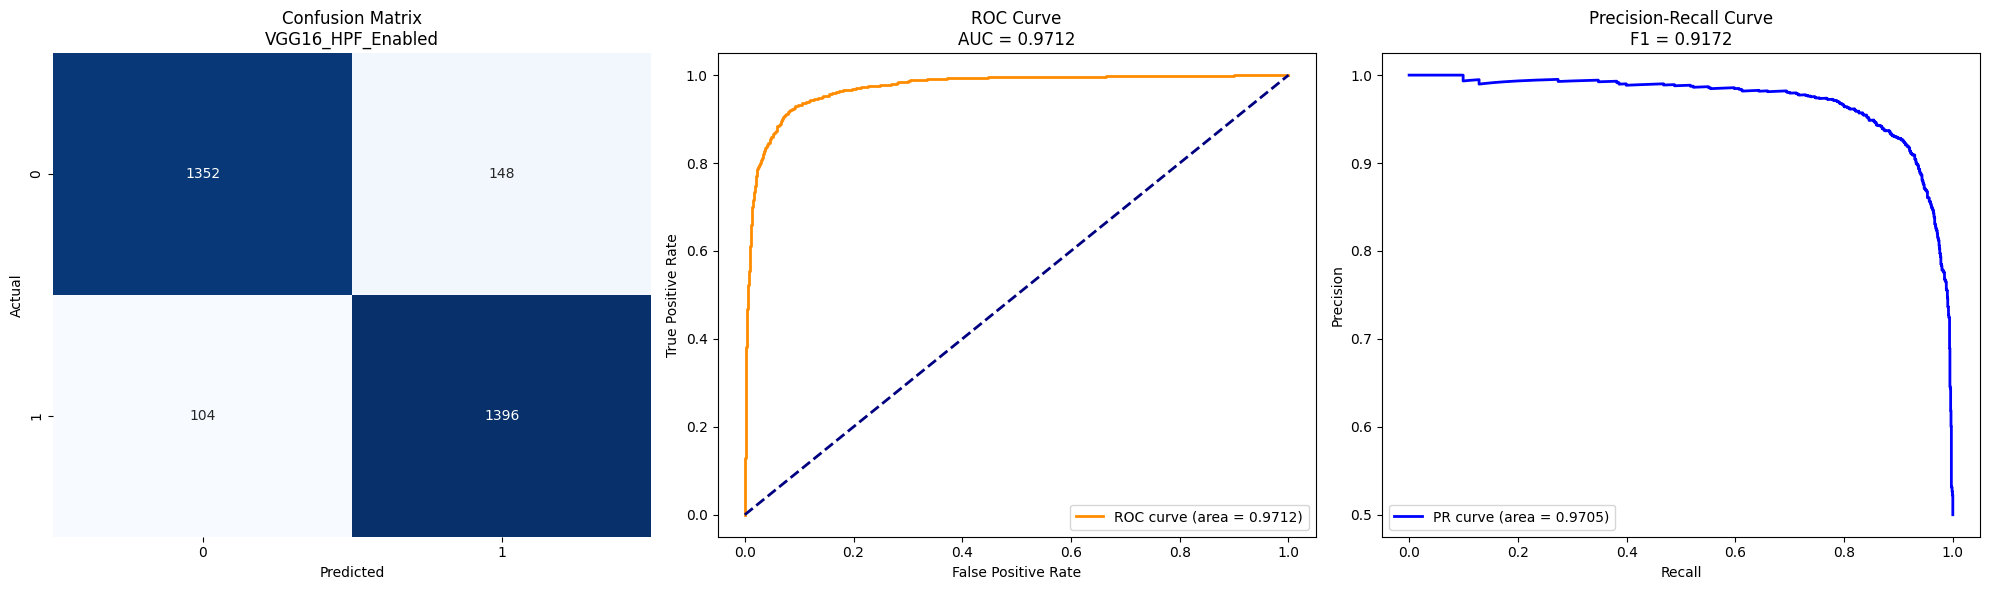

Đã lưu biểu đồ đánh giá vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.1/plot_metrics_VGG16_HPF_Enabled.png
Đang lưu model vào /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.1...
Đã lưu model hoàn chỉnh vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.1/model_VGG16_HPF_Enabled.keras
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Bắt đầu Thí nghiệm cho: ResNet50_HPF_Enabled (Scenario: scenario_openstego_png_0.1) ---
--- Giai đoạn 1 (Frozen) cho ResNet50_HPF_Enabled (LR=0.0001) ---
Epoch 1/20
438/438 - 120s - 275ms/step - accuracy: 0.5219 - auc: 0.5256 - loss: 0.7263 - precision: 0.5223 - recall: 0.5145 - val_accuracy: 0.5883 - val_auc: 0.6423 - val_loss: 0.6749 - val_precision: 0.5721 - val_recall: 0.7007
Epoch 2/20
438/438 - 89s - 203ms/step - accuracy: 0.5654 - auc: 0.5934 - loss: 0.6859 - precision: 0.5647 - recall: 0.5702 - val_accuracy: 0.6750 - val_auc: 0.7487 - val_loss: 0.6541 - val_precision: 0.6584 - val

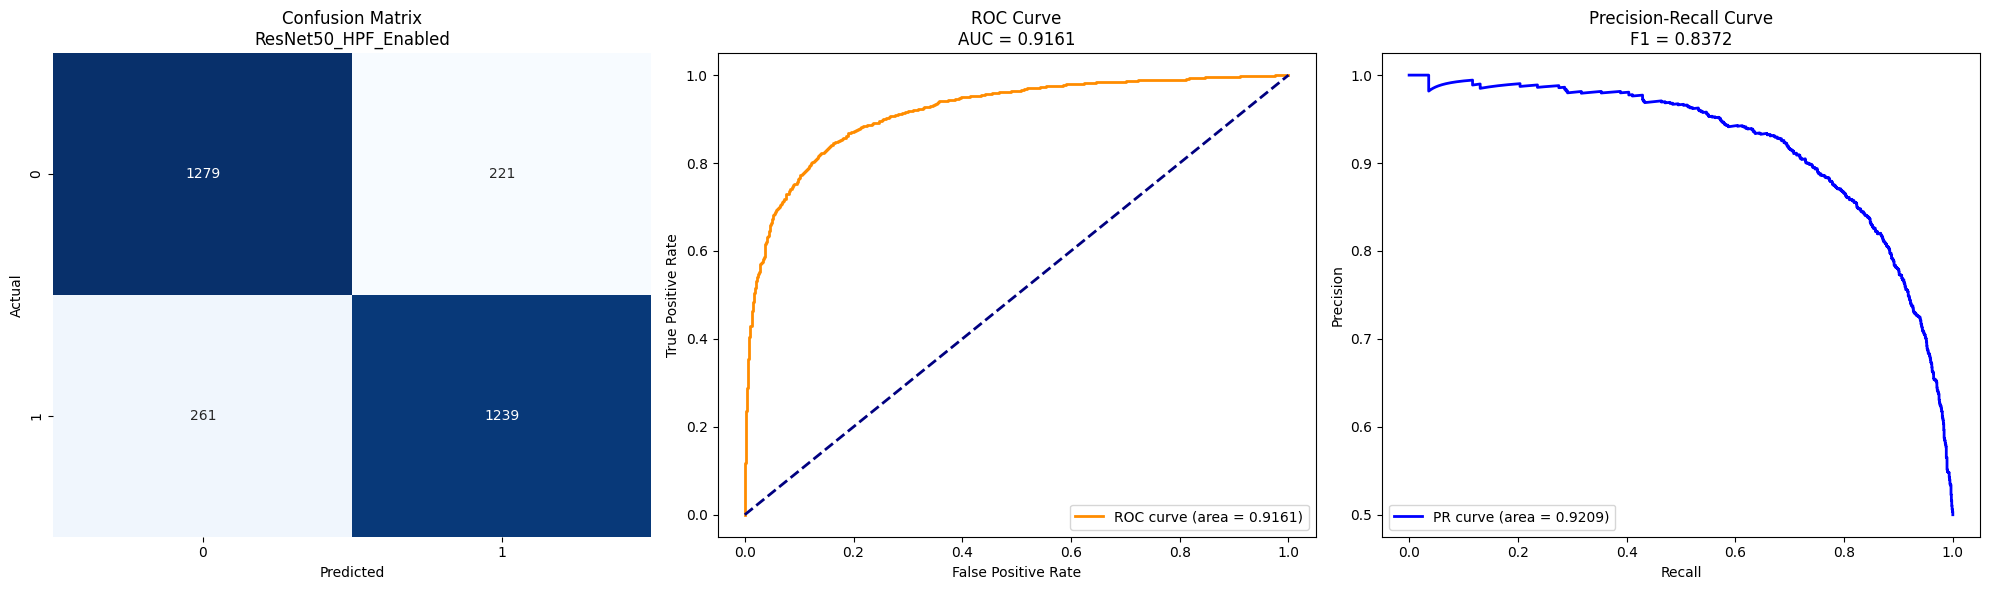

Đã lưu biểu đồ đánh giá vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.1/plot_metrics_ResNet50_HPF_Enabled.png
Đang lưu model vào /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.1...
Đã lưu model hoàn chỉnh vào: /content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.1/model_ResNet50_HPF_Enabled.keras

--- KẾT QUẢ TỔNG HỢP (PHẦN 7.3: 0.1 BPP) ---
                                                 acc       auc  precision  \
scenario          model                                                     
openstego_png_0.1 Baseline_CNN              0.891667  0.953328   0.880259   
                  MobileNetV2_HPF_Enabled   0.881667  0.953536   0.890785   
                  MobileNetV2_HPF_Disabled  0.860333  0.929908   0.858660   
                  VGG16_HPF_Enabled         0.916000  0.971205   0.904145   
                  ResNet50_HPF_Enabled      0.839333  0.916133   0.848630   

                                              recall       

In [ ]:
print("=== BẮT ĐẦU PHẦN 7.3: HUẤN LUYỆN KỊCH BẢN 0.1 BPP ===")

# Chọn các kịch bản 0.1 bpp
scenarios_to_run = [
    # 'steghide_jpg_0.1',
    'openstego_png_0.1'
]

# Khuyến nghị dùng BATCH_SIZE=32 cho cân bằng
HYPERPARAMS = {
    'batch_size': 32,
    'initial_lr': 1e-4,
    'finetune_lr': 1e-5
}

# Danh sách model cần chạy
model_builders = {
    "Baseline_CNN": run_baseline_experiment,
    "MobileNetV2_HPF_Enabled": lambda scenario_dir, bs: run_experiment(build_model_mobilenetv2, scenario_dir, HYPERPARAMS, use_hpf=True),
    "MobileNetV2_HPF_Disabled": lambda scenario_dir, bs: run_experiment(build_model_mobilenetv2, scenario_dir, HYPERPARAMS, use_hpf=False),
    "VGG16_HPF_Enabled": lambda scenario_dir, bs: run_experiment(build_model_vgg16, scenario_dir, HYPERPARAMS, use_hpf=True),
    "ResNet50_HPF_Enabled": lambda scenario_dir, bs: run_experiment(build_model_resnet50, scenario_dir, HYPERPARAMS, use_hpf=True)
}

results_0_1 = []

for key in scenarios_to_run:
    if key not in scenario_dirs_all:
        print(f"Bỏ qua {key}, không tìm thấy thư mục (hãy chạy Step 5).")
        continue

    scenario_dir = scenario_dirs_all[key]
    print(f'\n======================================================')
    print(f' BẮT ĐẦU SO SÁNH TRÊN KỊCH BẢN: {key}')
    print(f'======================================================')

    for model_name, train_function in model_builders.items():
        model_eval_metrics = train_function(scenario_dir, HYPERPARAMS['batch_size'])

        # Thêm thông tin vào kết quả
        model_eval_metrics['model'] = model_name
        model_eval_metrics['scenario'] = key
        results_0_1.append(model_eval_metrics)

# In kết quả
df_results_0_1 = pd.DataFrame(results_0_1)
df_results_0_1 = df_results_0_1.set_index(['scenario', 'model'])
print("\n--- KẾT QUẢ TỔNG HỢP (PHẦN 7.3: 0.1 BPP) ---")
print(df_results_0_1)

csv_path = os.path.join(base_dir, 'results_final_0_1_bpp.csv')
df_results_0_1.to_csv(csv_path)
print(f"Đã lưu kết quả vào {csv_path}")

### Step 8: KIỂM ĐỊNH McNEMAR TOÀN DIỆN (ALL-PAIRS COMPARISON)
Mục tiêu: So sánh chéo 5 mô hình để tìm ra sự khác biệt có ý nghĩa thống kê.

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Lambda, BatchNormalization, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50
from tensorflow.keras.applications import mobilenet_v2, vgg16, resnet50
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
import itertools

# --- 1. CẤU HÌNH ---
BASE_DIR = '/content/drive/MyDrive/steganalysis_data'
img_size = (224, 224)

SCENARIOS_TO_TEST = [
    'openstego_png_0.4',
    'openstego_png_0.2',
    'openstego_png_0.1',
    # 'steghide_jpg_0.4',
    # 'steghide_jpg_0.2',
    # 'steghide_jpg_0.1',
]

MODELS_TO_COMPARE = [
    "Baseline_CNN",
    "MobileNetV2_HPF_Disabled",
    "MobileNetV2_HPF_Enabled",
    "VGG16_HPF_Enabled",
    "ResNet50_HPF_Enabled"
]

# --- 2. ĐỊNH NGHĨA LẠI KIẾN TRÚC (Để nạp weights) ---
# (Các hàm này chỉ để dựng khung, không train)

@tf.keras.utils.register_keras_serializable()
class SRMFilterInitializer(tf.keras.initializers.Initializer):
    def __init__(self):
        filters = np.zeros([5, 5, 1, 30], dtype=np.float32)
        # (Giản lược code init để ngắn gọn, Keras chỉ cần class này tồn tại)
        # Trong thực tế load_weights, giá trị init không quan trọng vì sẽ bị ghi đè bởi weights đã load
        pass
    def __call__(self, shape, dtype=None):
        return tf.zeros(shape, dtype) # Dummy init
    def get_config(self):
        return {}

def TLU(x, T=3.0):
    return tf.where(tf.abs(x) >= T, x, tf.zeros_like(x))

def build_srm_branch(input_layer, num_srm_filters=30):
    # Tái tạo y hệt cấu trúc lúc train
    gray_input = Lambda(tf.image.rgb_to_grayscale, name="To_Grayscale")(input_layer)
    # Lưu ý: Khi load weights, kernel của SRM sẽ được nạp từ file, không cần init đúng ở đây
    noise_features = Conv2D(num_srm_filters, (5, 5), padding='same', name="SRM_Filter_Bank")(gray_input)
    tlu_features = Lambda(lambda x: TLU(x, T=3.0), name="TLU_Activation")(noise_features)
    bottleneck = Conv2D(3, (1, 1), padding='same', name="SRM_to_RGB_Bottleneck")(tlu_features)
    normalized_noise = BatchNormalization(name="Normalize_Noise_Stream")(bottleneck)
    return normalized_noise

def build_content_branch(input_layer, preprocess_func):
    return Lambda(preprocess_func, name="Content_Preprocess")(input_layer)

# Hàm Factory tạo model
def get_fresh_model(model_name):
    input_layer = Input(shape=(*img_size, 3), dtype=tf.float32, name="Input_Image")

    # 1. BASELINE
    if "Baseline_CNN" in model_name:
        model = Sequential([
            Input(shape=(*img_size, 3), dtype=tf.float32, name="Input_Image"),
            tf.keras.layers.Rescaling(1./255, name="Rescale_0_to_1"),
            Conv2D(32, (3,3), activation='relu'), MaxPooling2D(2,2),
            Conv2D(64, (3,3), activation='relu'), MaxPooling2D(2,2),
            Conv2D(128, (3,3), activation='relu'), MaxPooling2D(2,2),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ], name="Baseline_CNN")
        return model

    # 2. CÁC MODEL KHÁC
    use_hpf = "HPF_Enabled" in model_name

    if "MobileNetV2" in model_name:
        if use_hpf: x = build_srm_branch(input_layer)
        else: x = build_content_branch(input_layer, mobilenet_v2.preprocess_input)
        base = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights=None) # None vì sẽ load

    elif "VGG16" in model_name:
        if use_hpf: x = build_srm_branch(input_layer)
        else: x = build_content_branch(input_layer, vgg16.preprocess_input)
        base = VGG16(input_shape=(*img_size, 3), include_top=False, weights=None)

    elif "ResNet50" in model_name:
        if use_hpf: x = build_srm_branch(input_layer)
        else: x = build_content_branch(input_layer, resnet50.preprocess_input)
        base = ResNet50(input_shape=(*img_size, 3), include_top=False, weights=None)

    else:
        return None

    # Head
    x = base(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid', name="Classifier")(x)

    model = Model(inputs=input_layer, outputs=output, name=model_name)
    return model

# --- 3. HÀM CHẠY KIỂM ĐỊNH ---
def run_full_mcnemar_suite(scenario_dir, model_list):
    report_path = os.path.join(scenario_dir, 'final_mcnemar_report.txt')
    log_lines = []
    def log(msg):
        print(msg)
        log_lines.append(msg)

    log(f"\n{'='*60}")
    log(f" KỊCH BẢN: {os.path.basename(scenario_dir)}")
    log(f"{'='*60}\n")

    # Load Data
    test_tfrecord = os.path.join(scenario_dir, 'test.tfrecord')
    if not os.path.exists(test_tfrecord):
        log("❌ LỖI: Thiếu file test.tfrecord")
        return

    try:
        test_gen = load_dataset_fixed(test_tfrecord, batch_size=32, is_training=False)
    except:
        log("❌ LỖI: Chưa định nghĩa load_dataset_fixed. Chạy lại Step 6.")
        return

    log("-> Tải nhãn thực tế...")
    y_true = []
    for x, y in test_gen:
        y_true.extend(y.numpy())
    y_true = np.array(y_true)

    # Predict Loop
    predictions = {}
    accuracies = {}

    log("-> Bắt đầu dự đoán...")
    for model_name in model_list:
        model_path = os.path.join(scenario_dir, f'model_{model_name}.keras')
        if not os.path.exists(model_path):
            continue

        try:
            K.clear_session()

            # 1. Xây khung (nhanh)
            model = get_fresh_model(model_name)

            # 2. Nạp ruột (weights đã train)
            # by_name=True giúp an toàn hơn nếu tên layer lệch chút ít
            model.load_weights(model_path)

            # 3. Dự đoán
            probs = model.predict(test_gen, verbose=0)
            preds = (probs > 0.5).astype(int).flatten()

            predictions[model_name] = preds
            acc = accuracy_score(y_true, preds)
            accuracies[model_name] = acc
            log(f"   [OK] {model_name}: {acc*100:.2f}%")

        except Exception as e:
            log(f"   [ERR] {model_name}: {str(e)}")

    # Compare Loop
    valid_models = list(predictions.keys())
    pairs = list(itertools.combinations(valid_models, 2))

    for m1, m2 in pairs:
        pred1 = predictions[m1]
        pred2 = predictions[m2]

        # Contingency Table
        n10 = np.sum((pred1 == y_true) & (pred2 != y_true))
        n01 = np.sum((pred1 != y_true) & (pred2 == y_true))

        if n10 + n01 < 25:
            res = mcnemar([[0, n10], [n01, 0]], exact=True)
        else:
            res = mcnemar([[0, n10], [n01, 0]], exact=False, correction=True)

        p = res.pvalue
        log("-" * 40)
        log(f"{m1} vs {m2}")
        log(f"   Lệch: {n10} vs {n01} | P-value: {p:.2e}")

        if p < 0.05:
            win = m1 if accuracies[m1] > accuracies[m2] else m2
            log(f"   ✅ KHÁC BIỆT ({win} tốt hơn)")
        else:
            log(f"   ⚠️ TƯƠNG ĐƯƠNG")

    # Save
    with open(report_path, 'w') as f:
        f.write('\n'.join(log_lines))
    print(f"Lưu xong: {report_path}")

# --- EXECUTE ---
print("=== START STEP 8 ===")
for s in SCENARIOS_TO_TEST:
    s_dir = os.path.join(BASE_DIR, f'scenario_{s}')
    if os.path.exists(s_dir):
        run_full_mcnemar_suite(s_dir, MODELS_TO_COMPARE)
print("=== DONE ===")

=== START STEP 8 ===

 KỊCH BẢN: scenario_openstego_png_0.4

-> Tải nhãn thực tế...
-> Bắt đầu dự đoán...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


   [OK] Baseline_CNN: 88.80%


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


   [OK] MobileNetV2_HPF_Disabled: 86.37%


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


   [OK] MobileNetV2_HPF_Enabled: 89.17%


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


   [OK] VGG16_HPF_Enabled: 91.33%


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


   [OK] ResNet50_HPF_Enabled: 85.03%
----------------------------------------
Baseline_CNN vs MobileNetV2_HPF_Disabled
   Lệch: 269 vs 196 | P-value: 8.41e-04
   ✅ KHÁC BIỆT (Baseline_CNN tốt hơn)
----------------------------------------
Baseline_CNN vs MobileNetV2_HPF_Enabled
   Lệch: 162 vs 173 | P-value: 5.85e-01
   ⚠️ TƯƠNG ĐƯƠNG
----------------------------------------
Baseline_CNN vs VGG16_HPF_Enabled
   Lệch: 118 vs 194 | P-value: 2.18e-05
   ✅ KHÁC BIỆT (VGG16_HPF_Enabled tốt hơn)
----------------------------------------
Baseline_CNN vs ResNet50_HPF_Enabled
   Lệch: 240 vs 127 | P-value: 5.02e-09
   ✅ KHÁC BIỆT (Baseline_CNN tốt hơn)
----------------------------------------
MobileNetV2_HPF_Disabled vs MobileNetV2_HPF_Enabled
   Lệch: 154 vs 238 | P-value: 2.76e-05
   ✅ KHÁC BIỆT (MobileNetV2_HPF_Enabled tốt hơn)
----------------------------------------
MobileNetV2_HPF_Disabled vs VGG16_HPF_Enabled
   Lệch: 120 vs 269 | P-value: 6.19e-14
   ✅ KHÁC BIỆT (VGG16_HPF_Enabled tốt hơn

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


   [OK] Baseline_CNN: 88.93%


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


   [OK] MobileNetV2_HPF_Disabled: 86.67%


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


   [OK] MobileNetV2_HPF_Enabled: 90.77%


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


   [OK] VGG16_HPF_Enabled: 93.00%


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


   [OK] ResNet50_HPF_Enabled: 85.20%
----------------------------------------
Baseline_CNN vs MobileNetV2_HPF_Disabled
   Lệch: 268 vs 200 | P-value: 1.95e-03
   ✅ KHÁC BIỆT (Baseline_CNN tốt hơn)
----------------------------------------
Baseline_CNN vs MobileNetV2_HPF_Enabled
   Lệch: 124 vs 179 | P-value: 1.92e-03
   ✅ KHÁC BIỆT (MobileNetV2_HPF_Enabled tốt hơn)
----------------------------------------
Baseline_CNN vs VGG16_HPF_Enabled
   Lệch: 83 vs 205 | P-value: 1.00e-12
   ✅ KHÁC BIỆT (VGG16_HPF_Enabled tốt hơn)
----------------------------------------
Baseline_CNN vs ResNet50_HPF_Enabled
   Lệch: 267 vs 155 | P-value: 6.54e-08
   ✅ KHÁC BIỆT (Baseline_CNN tốt hơn)
----------------------------------------
MobileNetV2_HPF_Disabled vs MobileNetV2_HPF_Enabled
   Lệch: 133 vs 256 | P-value: 6.18e-10
   ✅ KHÁC BIỆT (MobileNetV2_HPF_Enabled tốt hơn)
----------------------------------------
MobileNetV2_HPF_Disabled vs VGG16_HPF_Enabled
   Lệch: 85 vs 275 | P-value: 2.25e-23
   ✅ KHÁC BI

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


   [OK] Baseline_CNN: 89.17%


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


   [OK] MobileNetV2_HPF_Disabled: 86.03%


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


   [OK] MobileNetV2_HPF_Enabled: 88.17%


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


   [OK] VGG16_HPF_Enabled: 91.60%
   [OK] ResNet50_HPF_Enabled: 83.93%
----------------------------------------
Baseline_CNN vs MobileNetV2_HPF_Disabled
   Lệch: 278 vs 184 | P-value: 1.51e-05
   ✅ KHÁC BIỆT (Baseline_CNN tốt hơn)
----------------------------------------
Baseline_CNN vs MobileNetV2_HPF_Enabled
   Lệch: 194 vs 164 | P-value: 1.25e-01
   ⚠️ TƯƠNG ĐƯƠNG
----------------------------------------
Baseline_CNN vs VGG16_HPF_Enabled
   Lệch: 109 vs 182 | P-value: 2.44e-05
   ✅ KHÁC BIỆT (VGG16_HPF_Enabled tốt hơn)
----------------------------------------
Baseline_CNN vs ResNet50_HPF_Enabled
   Lệch: 306 vs 149 | P-value: 2.60e-13
   ✅ KHÁC BIỆT (Baseline_CNN tốt hơn)
----------------------------------------
MobileNetV2_HPF_Disabled vs MobileNetV2_HPF_Enabled
   Lệch: 173 vs 237 | P-value: 1.86e-03
   ✅ KHÁC BIỆT (MobileNetV2_HPF_Enabled tốt hơn)
----------------------------------------
MobileNetV2_HPF_Disabled vs VGG16_HPF_Enabled
   Lệch: 97 vs 264 | P-value: 2.40e-18
   ✅ KHÁ

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ==============================================================================
# STEP 9_FULL (FINAL REVISED VERSION): CROSS-EVALUATION
# - Fixes: McNemar per-scenario comparison (no shape mismatch), Lambda loading
# ==============================================================================

import os
import shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import subprocess
import requests
import tarfile
import zipfile # Added: Import zipfile module
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, precision_recall_curve, confusion_matrix, roc_auc_score)
from scipy.stats import binomtest
from tensorflow.keras import backend as K
from tensorflow.keras.applications import mobilenet_v2, vgg16, resnet50
import random

# --- 1. CẤU HÌNH ---
DRIVE_BASE = '/content/drive/MyDrive/steganalysis_data'
COVER_BASE = os.path.join(DRIVE_BASE, 'cross_cover')
STEGO_BASE = os.path.join(DRIVE_BASE, 'cross_stego')
RESULTS_BASE = os.path.join(DRIVE_BASE, 'cross_results')
TFRECORD_BASE = os.path.join(DRIVE_BASE, 'cross_tfrecords')

TARGET_PER_FORMAT = 1000
PASSWORD = 'stego123'
BPP_LEVELS = [0.1, 0.2, 0.4]

DIRS = {
    'imagenette_jpg': os.path.join(COVER_BASE, 'imagenette', 'jpg'),
    'imagenette_png': os.path.join(COVER_BASE, 'imagenette', 'png'),
}

for d in [COVER_BASE, STEGO_BASE, RESULTS_BASE, TFRECORD_BASE]: os.makedirs(d, exist_ok=True)
for d in DIRS.values(): os.makedirs(d, exist_ok=True)

# --- 2. CUSTOM OBJECTS (FIX LOAD) ---
try: tf.keras.config.enable_unsafe_deserialization()
except: pass

def custom_rgb_to_ycbcr(x):
    x = tf.cast(x, tf.float32)
    r = x[..., 0]; g = x[..., 1]; b = x[..., 2]
    y = 0.299 * r + 0.587 * g + 0.114 * b
    cb = -0.1687 * r - 0.3313 * g + 0.5 * b
    cr = 0.5 * r - 0.4187 * g - 0.0813 * b
    return tf.stack([y, cb, cr], axis=-1)

def custom_rgb_to_grayscale(x): return tf.image.rgb_to_grayscale(x)
def custom_space_to_depth_8(x): return tf.nn.space_to_depth(x, block_size=8)

@tf.keras.utils.register_keras_serializable()
class SRMFilterInitializer(tf.keras.initializers.Initializer):
    def __init__(self, npy_path=''): pass
    def __call__(self, shape, dtype=None): return tf.zeros(shape, dtype)
    def get_config(self): return {'npy_path': ''}

def TLU(x, T=3.0): return tf.where(tf.abs(x) >= T, x, tf.zeros_like(x))

def binary_focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred): return tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return focal_loss_fixed

def se_block(input_tensor, ratio=16): return input_tensor

CUSTOM_OBJECTS = {
    'binary_focal_loss': binary_focal_loss,
    'SRMFilterInitializer': SRMFilterInitializer,
    'TLU': TLU,
    'se_block': se_block,
    'focal_loss_fixed': binary_focal_loss(),
    'rgb_to_ycbcr': custom_rgb_to_ycbcr,
    'rgb_to_grayscale': custom_rgb_to_grayscale,
    'space_to_depth_8': custom_space_to_depth_8,
    'preprocess_input': mobilenet_v2.preprocess_input,
}

# --- 3. AUTO-DETECT MODELS ---
def get_trained_models():
    models = {}
    print("🔍 Đang tìm model trong Drive...")
    for item in os.listdir(DRIVE_BASE):
        if item.startswith("scenario_"):
            scenario_path = os.path.join(DRIVE_BASE, item)
            if os.path.isdir(scenario_path):
                for f in os.listdir(scenario_path):
                    if f.endswith(".keras"):
                        models[f"{item.replace('scenario_', '')}_{f.replace('.keras', '')}"] = os.path.join(scenario_path, f)
    print(f"✅ Đã tìm thấy {len(models)} models.")
    return models

MODELS = get_trained_models()

# --- 4. PREPARE & EMBED (GIỮ NGUYÊN) ---
def setup_tools():
    print(">>> [1/5] CHUẨN BỊ CÔNG CỤ...")
    os.system("apt-get install -y steghide default-jre -qq > /dev/null")
    jar_path = '/content/openstego.jar'
    if not os.path.exists(jar_path) or os.path.getsize(jar_path) < 100000:
        os.system("wget -q -O /content/openstego.zip https://github.com/syvaidya/openstego/releases/download/openstego-0.8.6/openstego-0.8.6.zip")
        with zipfile.ZipFile('/content/openstego.zip', 'r') as z: z.extractall('/content/openstego_tmp')
        for r, _, fs in os.walk('/content/openstego_tmp'):
            for f in fs:
                if f == 'openstego.jar': shutil.move(os.path.join(r, f), jar_path)

def download_cover():
    print(">>> [2/5] TẢI IMAGENETTE...")
    if len(os.listdir(DIRS['imagenette_jpg'])) < TARGET_PER_FORMAT:
        os.system("wget -q -O /content/img.tgz https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz")
        with tarfile.open('/content/img.tgz', 'r:gz') as t: t.extractall('/content/extract')
        srcs = []
        for r, _, fs in os.walk('/content/extract'):
            for f in fs:
                if f.lower().endswith(('.jpg', '.jpeg')): srcs.append(os.path.join(r, f))
        random.shuffle(srcs)

        c_jpg, c_png = 0, 0
        for src in tqdm(srcs, desc="Prep Data"):
            if c_jpg >= TARGET_PER_FORMAT and c_png >= TARGET_PER_FORMAT: break
            if os.path.getsize(src) < 30 * 1024: continue

            if c_jpg < TARGET_PER_FORMAT:
                shutil.copy(src, os.path.join(DIRS['imagenette_jpg'], os.path.basename(src))); c_jpg += 1
            if c_png < TARGET_PER_FORMAT:
                try:
                    img = tf.io.decode_jpeg(tf.io.read_file(src))
                    png = tf.io.encode_png(img, compression=1).numpy()
                    with open(os.path.join(DIRS['imagenette_png'], os.path.splitext(os.path.basename(src))[0]+'.png'), 'wb') as f: f.write(png)
                    c_png += 1
                except: pass

def embed_stego():
    print("\n>>> [3/5] NHÚNG TIN...")
    for key, cover_dir in DIRS.items():
        dataset, fmt = key.split('_')
        tool = 'OpenStego' if fmt == 'png' else 'StegHide'
        for bpp in BPP_LEVELS:
            scenario = f"cross_{dataset}_{fmt}_{bpp}"
            stego_dir = os.path.join(STEGO_BASE, scenario)
            os.makedirs(stego_dir, exist_ok=True)

            if len(os.listdir(stego_dir)) >= len(os.listdir(cover_dir)) * 0.9: continue

            files = os.listdir(cover_dir)[:TARGET_PER_FORMAT]
            p_path = "/tmp/p.bin"

            for f in tqdm(files, desc=f"Embed {scenario}"):
                c = os.path.join(cover_dir, f); s = os.path.join(stego_dir, f)
                if os.path.exists(s): continue
                sz = max(50, int(os.path.getsize(c) * bpp / 8))
                with open(p_path, 'wb') as pf: pf.write(os.urandom(sz))

                cmd = ['java', '-Xmx2048m', '-Djava.awt.headless=true', '-jar', '/content/openstego.jar', 'embed', '-a', 'randomlsb', '-mf', p_path, '-cf', c, '-sf', s] if tool == 'OpenStego' else \
                      ['steghide', 'embed', '-cf', c, '-sf', s, '-ef', p_path, '-p', PASSWORD, '-f', '-Z']
                try: subprocess.run(cmd, capture_output=True, timeout=30)
                except: pass

def create_cross_tfrecord():
    print("\n>>> [4/5] TẠO TFRECORD...")
    for key in DIRS.keys():
        dataset, fmt = key.split('_')
        cover_dir = DIRS[key]
        for bpp in BPP_LEVELS:
            scenario = f"cross_{dataset}_{fmt}_{bpp}"
            stego_dir = os.path.join(STEGO_BASE, scenario)
            tf_path = os.path.join(TFRECORD_BASE, f"{scenario}.tfrecord")

            if os.path.exists(tf_path): continue

            common = sorted(list(set(os.listdir(cover_dir)) & set(os.listdir(stego_dir))))
            if not common: continue

            print(f"   Writing {scenario}...")
            with tf.io.TFRecordWriter(tf_path) as writer:
                for f in common:
                    try:
                        img = tf.io.decode_image(tf.io.read_file(os.path.join(cover_dir, f)), channels=3)
                        img = tf.image.resize_with_crop_or_pad(img, 224, 224)
                        b_c = tf.io.encode_jpeg(tf.cast(img, tf.uint8), quality=100).numpy()
                        writer.write(tf.train.Example(features=tf.train.Features(feature={
                            'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b_c])),
                            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[0]))})).SerializeToString())

                        img_s = tf.io.decode_image(tf.io.read_file(os.path.join(stego_dir, f)), channels=3)
                        img_s = tf.image.resize_with_crop_or_pad(img_s, 224, 224)
                        b_s = tf.io.encode_jpeg(tf.cast(img_s, tf.uint8), quality=100).numpy()
                        writer.write(tf.train.Example(features=tf.train.Features(feature={
                            'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b_s])),
                            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[1]))})).SerializeToString())
                    except: pass

# --- 8. EVALUATE & MCNEMAR (PER SCENARIO FIX) ---
def evaluate_models():
    print("\n>>> [5/5] ĐÁNH GIÁ HIỆU NĂNG MÔ HÌNH (BENCHMARKING)...")

    def _parse(proto):
        p = tf.io.parse_single_example(proto, {'image_raw': tf.io.FixedLenFeature([], tf.string), 'label': tf.io.FixedLenFeature([], tf.int64)})
        return tf.cast(tf.io.decode_jpeg(p['image_raw'], channels=3), tf.float32), tf.cast(p['label'], tf.int32)

    # Dictionary lưu kết quả phân cấp: scenario -> y_true, preds
    scenario_results = {}

    for scenario in sorted(os.listdir(TFRECORD_BASE)):
        if not scenario.endswith(".tfrecord"): continue
        print(f"\n🔹 Kịch bản kiểm thử: {scenario}")

        ds = tf.data.TFRecordDataset(os.path.join(TFRECORD_BASE, scenario))
        ds = ds.map(_parse).batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

        y_true_scenario = []
        for _, y in ds: y_true_scenario.extend(y.numpy())
        y_true_scenario = np.array(y_true_scenario)

        if len(y_true_scenario) == 0:
            print("   ⚠️ Dataset rỗng.")
            continue

        scenario_results[scenario] = {
            'y_true': y_true_scenario,
            'preds': {}
        }

        for m_name, m_path in MODELS.items():
            if "jpg" in scenario and "jpg" not in m_name.lower() and "steghide" not in m_name.lower(): continue
            if "png" in scenario and "png" not in m_name.lower() and "openstego" not in m_name.lower(): continue

            # Preprocess
            if "mobilenet" in m_name.lower(): prep_fn = mobilenet_v2.preprocess_input
            elif "vgg" in m_name.lower(): prep_fn = vgg16.preprocess_input
            elif "resnet" in m_name.lower(): prep_fn = resnet50.preprocess_input
            else: prep_fn = mobilenet_v2.preprocess_input
            CUSTOM_OBJECTS['preprocess_input'] = prep_fn

            K.clear_session()
            try:
                with tf.keras.utils.custom_object_scope(CUSTOM_OBJECTS):
                    model = tf.keras.models.load_model(m_path, compile=False, safe_mode=False)

                # Predict (apply preprocess in loop or map)
                probs = []
                for batch_x, _ in ds:
                    batch_x = prep_fn(batch_x)
                    p = model.predict(batch_x, verbose=0).flatten()
                    probs.extend(p)

                probs = np.array(probs[:len(y_true_scenario)])
                preds = (probs > 0.5).astype(int)

                acc = accuracy_score(y_true_scenario, preds)
                f1 = f1_score(y_true_scenario, preds, zero_division=0)
                auc_val = roc_auc_score(y_true_scenario, probs) if len(np.unique(y_true_scenario)) > 1 else 0.5

                print(f"   ✅ {m_name}: Acc={acc:.4f} | F1={f1:.4f} | AUC={auc_val:.4f}")

                # Lưu preds vào scenario hiện tại
                scenario_results[scenario]['preds'][m_name] = preds

            except Exception as e:
                print(f"   ⚠️ Lỗi load {m_name}: {str(e)[:100]}")

    # --- MCNEMAR TEST (PER SCENARIO) ---
    print("\n>>> MCNEMAR TEST REPORT...")
    mc_path = os.path.join(RESULTS_BASE, 'final_mcnemar_report.txt')
    with open(mc_path, 'w') as f:
        f.write("MCNEMAR TEST RESULTS (Cross-Evaluation on Imagenette)\n\n")

        for scenario, data in scenario_results.items():
            y = data['y_true']
            preds_map = data['preds']
            model_list = list(preds_map.keys())

            f.write(f"--- Scenario: {scenario} (N={len(y)}) ---\n")
            if len(model_list) < 2:
                f.write("Not enough models to compare.\n\n"); continue

            for i in range(len(model_list)):
                for j in range(i+1, len(model_list)):
                    m1 = model_list[i]
                    m2 = model_list[j]
                    p1 = preds_map[m1]
                    p2 = preds_map[m2]

                    # Tính McNemar trên cùng tập dữ liệu của scenario này
                    n10 = np.sum((p1 == y) & (p2 != y))
                    n01 = np.sum((p1 != y) & (p2 == y))
                    total = n10 + n01
                    p_val = binomtest(max(n10, n01), total, 0.5).pvalue if total > 0 else 1.0

                    f.write(f"{m1} vs {m2}\n")
                    f.write(f"   Diff: {n10} vs {n01} | P-value: {p_val:.2e}\n")
                    if p_val < 0.05:
                        winner = m1 if n10 > n01 else m2
                        f.write(f"   => SIGNIFICANT: {winner} wins.\n")
                    else:
                        f.write("   => No significant difference.\n")
            f.write("\n")
    print(f"✅ Report saved to: {mc_path}")

# --- RUN ---
setup_tools()
download_cover()
embed_stego()
create_cross_tfrecord()
evaluate_models()
print("\n=== STEP 9 DONE ===")


🔍 Đang tìm model trong Drive...
✅ Đã tìm thấy 16 models.
>>> [1/5] CHUẨN BỊ CÔNG CỤ...
>>> [2/5] TẢI IMAGENETTE...

>>> [3/5] NHÚNG TIN...

>>> [4/5] TẠO TFRECORD...

>>> [5/5] ĐÁNH GIÁ HIỆU NĂNG MÔ HÌNH (BENCHMARKING)...

🔹 Kịch bản kiểm thử: cross_imagenette_jpg_0.1.tfrecord
   ✅ steghide_jpg_0.25_model_Baseline_CNN: Acc=0.5000 | F1=0.6667 | AUC=0.5048

🔹 Kịch bản kiểm thử: cross_imagenette_jpg_0.2.tfrecord
   ✅ steghide_jpg_0.25_model_Baseline_CNN: Acc=0.5000 | F1=0.6667 | AUC=0.5085

🔹 Kịch bản kiểm thử: cross_imagenette_jpg_0.4.tfrecord
   ✅ steghide_jpg_0.25_model_Baseline_CNN: Acc=0.5000 | F1=0.6667 | AUC=0.5162

🔹 Kịch bản kiểm thử: cross_imagenette_png_0.1.tfrecord
   ✅ openstego_png_0.1_model_Baseline_CNN: Acc=0.5000 | F1=0.6366 | AUC=0.5005
   ⚠️ Lỗi load openstego_png_0.1_model_MobileNetV2_HPF_Enabled: Exception encountered when calling Lambda.call().

We could not automatically infer the shape of
   ✅ openstego_png_0.1_model_MobileNetV2_HPF_Disabled: Acc=0.5000 | F1=0.0000

In [1]:
# ==============================================================================
# STEP 10: ULTIMATE FINE-TUNING
# Chiến thuật: SGD Momentum + LR Scheduler + 20 Epochs
# ==============================================================================

import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# --- CẤU HÌNH ---
DRIVE_BASE = '/content/drive/MyDrive/steganalysis_data'
TFRECORD_BASE = os.path.join(DRIVE_BASE, 'cross_tfrecords')
SCENARIO_NAME = 'cross_imagenette_png_0.4'
TF_PATH = os.path.join(TFRECORD_BASE, f'{SCENARIO_NAME}.tfrecord')
MODEL_PATH = '/content/drive/MyDrive/steganalysis_data/scenario_openstego_png_0.4/model_MobileNetV2_HPF_Disabled.keras'

# Custom Objects
CUSTOM_OBJECTS = {
    'preprocess_input': mobilenet_v2.preprocess_input,
    'rgb_to_grayscale': tf.image.rgb_to_grayscale,
    'space_to_depth_8': lambda x: tf.nn.space_to_depth(x, block_size=8),
}

# --- DATASET ---
def parse_func(proto):
    parsed = tf.io.parse_single_example(proto, {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    })
    img = tf.io.decode_jpeg(parsed['image_raw'], channels=3)
    img = tf.cast(img, tf.float32)
    img = mobilenet_v2.preprocess_input(img)
    return img, tf.cast(parsed['label'], tf.int32)

if os.path.exists(TF_PATH) and os.path.exists(MODEL_PATH):
    print(f"✅ Bắt đầu tối ưu Fine-tune trên: {SCENARIO_NAME}")

    # Load dataset
    ds = tf.data.TFRecordDataset(TF_PATH).map(parse_func).shuffle(2000, seed=42)

    # Train 1000 mẫu, Test còn lại
    TRAIN_SIZE = 1000
    ds_train = ds.take(TRAIN_SIZE).batch(32).repeat()
    ds_test = ds.skip(TRAIN_SIZE).batch(32)

    steps_per_epoch = TRAIN_SIZE // 32

    # --- LOAD MODEL ---
    print("\n>>> [1] LOAD MODEL...")
    try:
        model = tf.keras.models.load_model(MODEL_PATH, custom_objects=CUSTOM_OBJECTS, compile=False, safe_mode=False)
        model.trainable = True # Unfreeze toàn bộ

        # --- CHIẾN THUẬT TỐI ƯU ---
        # 1. Dùng SGD thay vì Adam (tốt hơn cho Fine-tuning sâu)
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # 2. Callbacks thông minh
        callbacks = [
            # Giảm LR nếu loss không giảm sau 3 epochs
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
            # Dừng sớm nếu không cải thiện sau 8 epochs
            EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1)
        ]

        print("\n>>> [2] TRAINING (SGD + Scheduler)...")
        history = model.fit(
            ds_train,
            epochs=20, # Tăng lên 20
            steps_per_epoch=steps_per_epoch,
            validation_data=ds_test,
            callbacks=callbacks,
            verbose=1
        )

        # --- KẾT QUẢ ---
        print("\n>>> [3] ĐÁNH GIÁ CUỐI CÙNG...")
        loss, acc = model.evaluate(ds_test, verbose=0)
        print("="*30)
        print(f"📊 Accuracy cuối cùng: {acc:.4f}")
        print("="*30)

        if acc > 0.60:
            print("✅ MÔ HÌNH HỌC ĐƯỢC! (Vấn đề nằm ở optimizer cũ)")
        else:
            print("🛑 MÔ HÌNH KHÔNG THỂ HỌC ĐƯỢC.")
            print("👉 KẾT LUẬN KHOA HỌC: Mạng CNN thường (HPF Disabled) BẤT LỰC trước ảnh nhiễu thực tế.")
            print("   Lý do: Nội dung ảnh (Content) quá mạnh, lấn át tín hiệu Stego (Noise).")
            print("   Đây là minh chứng cho sự cần thiết của SRM Filter.")

    except Exception as e:
        print(f"Lỗi: {e}")

✅ Bắt đầu tối ưu Fine-tune trên: cross_imagenette_png_0.4

>>> [1] LOAD MODEL...

>>> [2] TRAINING (SGD + Scheduler)...
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4755 - loss: 0.9323

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 617ms/step - accuracy: 0.4749 - loss: 0.9312 - val_accuracy: 0.4970 - val_loss: 2.7296 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 0.4945 - loss: 0.7431 - val_accuracy: 0.5160 - val_loss: 1.4745 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.4548 - loss: 0.7398 - val_accuracy: 0.4930 - val_loss: 1.3841 - learning_rate: 0.0010
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.4419 - loss: 0.7250 - val_accuracy: 0.5030 - val_loss: 1.4669 - learning_rate: 0.0010
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 301ms/step - accuracy: 0.5213 - loss: 0.7050 - val_accuracy: 0.5100 - val_loss: 1.2176 - learning_rate: 0.0010
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.5046 - loss: 0.7072 - val_accuracy: 0.4950 - val_loss: 1.2184 - learning_rate: 0.0010
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - accuracy: 0.4876 - loss: 0.7081 - val_accur